In [1]:
from qiskit import *
from math import log2, ceil
from qiskit.circuit.library import XGate, UnitaryGate, MCXGate
from qiskit.circuit import Gate

In [2]:
from typing import List
import re
import copy
import time
from pathlib import Path
import numpy as np
from itertools import product
from math import log2
from enum import Enum

"""
Arquivo para realizacao da sintese do circuito feito pelo Raphael Bernadino
Implementacao original: https://github.com/raphaelbernardino/rblk
"""


class Alvo:
    def __init__(self, linha, mapa=None):
        self.linha_original = int(linha)

        if mapa is None:
            self.linha = int(linha)
        else:
            if linha >= len(mapa):
                self.linha = linha
            else:
                self.linha = int(mapa[linha])

        if self.linha < 0:
            raise Exception('Alvo inválido! Linha negativa.')

    def modifica_linha(self, modificacao: int):
        """
        Modifica a linha atual. Para aumentar a linha informe um valor positivo, e para diminuir, um valor negativo.

        modificacao: int
        """
        self.linha = self.linha + modificacao

    def remapeia(self, mapa):
        self.linha = mapa[self.linha]

    def __repr__(self):
        return f'b{self.linha}'

    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False

        if self.linha != other.linha:
            return False

        return True

    def __lt__(self, other):
        if not isinstance(other, self.__class__):
            raise Exception('Não é possível comparar Alvo com outro tipo.')

        return self.linha < other.linha

    def __hash__(self):
        return id(self.linha) * hash(self.linha + 1)



class States(Enum):
    alvo = 'av'
    ctrl_ausente = None
    ctrl_positivo = True
    ctrl_negativo = False

    def __eq__(self, other):
        other_value = other

        if type(other_value) is self:
            other_value = other_value.value

        return other_value == self.value

    def __repr__(self):
        if self.value == self.ctrl_positivo:
            return 'Positivo'

        if self.value == self.ctrl_negativo:
            return 'Negativo'

        if self.value == self.ctrl_ausente:
            return 'Ausente'

        # return str(self.value)
        return 'Alvo'

    def __str__(self):
        return self.__repr__()
    

class Controle:
    def __init__(self, linha, sinal, mapa=None):
        self.linha_original = int(linha)

        if mapa is None:
            self.linha = int(linha)
        else:
            if linha >= len(mapa):
                self.linha = linha
            else:
                self.linha = int(mapa[linha])

        if isinstance(sinal, bool):
            self.sinal = sinal

        elif isinstance(sinal, States):
            self.sinal = bool(sinal.value)

        else:
            raise Exception('Sinal inválido! Não é booleano.')

        if self.linha < 0:
            raise Exception('Controle inválido! Linha negativa.')

    def modifica_linha(self, modificacao: int):
        """
        Modifica a linha atual. Para aumentar a linha informe um valor positivo, e para diminuir, um valor negativo.

        modificacao: int
        """
        self.linha = self.linha + modificacao

    def remapeia(self, mapa):
        self.linha = mapa[self.linha]

    def eh_sinal_positivo(self):
        return self.sinal == States.ctrl_positivo

    def eh_sinal_negativo(self):
        return self.sinal == States.ctrl_negativo

    def inverte_sinal(self):
        self.sinal = not self.sinal

    def possui_sinal_inverso(self, other):
        if not isinstance(other, self.__class__):
            return False

        if self.linha != other.linha:
            return False

        if self.sinal == other.sinal:
            return False

        return True

    def __repr__(self):
        s = "" if self.sinal else "'"
        return f'b{self.linha}{s}'

    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False

        if self.sinal != other.sinal:
            return False

        if self.linha != other.linha:
            return False

        return True

    def __lt__(self, other):
        if not isinstance(other, self.__class__):
            raise Exception('Não é possível comparar Controle com outro tipo.')

        return self.linha < other.linha

    def __hash__(self):
        return id(self.sinal) * hash(self.linha + 1)


class Toffoli:
    def __init__(self, alvos: List[Alvo], controles: List[Controle], mapa=None):
        self.tamanho_bits = 1 + len(controles)

        self.mapeamento = mapa
        if mapa is None:
            # k = [(i, i) for i in range(self.tamanho_bits)]

            # busca a maior linha de alvo
            maior_linha_alvo = 0
            if isinstance(alvos, list):
                maior_linha_alvo = alvos[0].linha
            elif isinstance(alvos, Alvo):
                maior_linha_alvo = alvos.linha
            else:
                raise Exception(f'Alvo não possui um tipo identificavel. (alvos: {type(alvos)})')

            # busca a maior linha de controle
            maior_linha_controle = 0
            if len(controles) > 0:
                maior_linha_controle = max([ctrl.linha for ctrl in controles])

            # identifica a maior linha entre controles e alvos
            maior_linha = max(maior_linha_alvo, maior_linha_controle)
            # print(f'Maior linha:: {maior_linha_alvo} :: {maior_linha_controle} ==> {maior_linha}')

            # gera o mapeamento a partir da maior linha
            k = [(i, i) for i in range(maior_linha + 1)]
            self.mapeamento = dict(k)

        self.alvos = self.__inicializa_alvos(alvos)
        self.controles = self.__inicializa_controles(controles)

    # def mapeia(self, mapa):
    #     # realiza mapeamento do alvo
    #     self.alvos.mapeia(mapa)
    #
    #     # realiza mapeamento dos controles
    #     for controle in self.controles:
    #         controle.mapeia(mapa)

    def modifica_linhas(self, mapeamento: dict):
        """
        Modifica a linha atual através de mapeamento.

        @param mapeamento: Um dicionário contendo o mapeamento a ser realizado.
        """
        linha_alvo = self.alvos.linha
        nova_linha_alvo = mapeamento[linha_alvo]

        diferenca_linha = linha_alvo - nova_linha_alvo
        self.alvos.modifica_linha(diferenca_linha)

        for ctrl in self.controles:
            linha_ctrl = ctrl.linha
            nova_linha_ctrl = mapeamento[linha_ctrl]

            diferenca_linha = linha_ctrl - nova_linha_ctrl
            ctrl.modifica_linha(diferenca_linha)

    def __inicializa_alvos(self, alvos):
        alvo = list()

        if isinstance(alvos, Alvo):
            um_alvo = copy.deepcopy(alvos)
            um_alvo.linha_original = alvos.linha
            um_alvo.linha = self.mapeamento[alvos.linha]
            alvo.append(um_alvo)

        if isinstance(alvos, list):
            # alvo = [copy.deepcopy(a) for a in alvos]
            for a in alvos:
                um_alvo = copy.deepcopy(a)
                um_alvo.linha_original = a.linha
                # print(f'Mapeamento: {self.mapeamento}')
                # print(f'Alvos: {alvos}')
                # print(f'Linha: {a.linha}')
                # print(f'um_alvo: {um_alvo} :: {um_alvo.linha} :: {um_alvo.linha_original}')
                um_alvo.linha = self.mapeamento[a.linha]
                alvo.append(um_alvo)

        if isinstance(alvos, int):
            um_alvo = Alvo(alvos, self.mapeamento)
            alvo.append(um_alvo)

        if len(alvo) != 1:
            raise Exception('Alvos inválidos! É necessário apenas um alvo.')

        return alvo[0]

    def __inicializa_controles(self, ctrls: List[Controle]):
        controles = list()

        for ctrl in ctrls:
            um_controle = copy.deepcopy(ctrl)
            # print(f'Mapeamento: {self.mapeamento}')
            # print(f'Linha Original: {ctrl.linha} :: {um_controle.linha_original} :: {um_controle.linha}')
            um_controle.linha_original = ctrl.linha
            um_controle.linha = self.mapeamento[ctrl.linha]
            controles.append(um_controle)

        return controles

    def remapeia(self, mapa):
        self.alvos.remapeia(mapa)

        for ctrl in self.controles:
            ctrl.remapeia(mapa)

    def adiciona_controles(self, controles):
        # linhas_usadas = self.obtem_linhas_de_controle_usadas()
        linhas_usadas = self.obtem_linhas_usadas()
        controles_antigos = copy.deepcopy(self.controles)

        for ctrl in controles:
            if ctrl.linha in linhas_usadas:
                self.controles = controles_antigos
                raise Exception('Linha {ctrl.linha} já está ocupada')

            um_controle = copy.deepcopy(ctrl)
            self.controles.append(um_controle)
            self.tamanho_bits = len(self.obtem_linhas_usadas())

    def remove_controle(self, ctrl):
        if ctrl in self.controles:
            self.controles.remove(ctrl)
            self.tamanho_bits = len(self.obtem_linhas_usadas())

    def remove_controles(self, controles):
        for ctrl in controles:
            self.remove_controle(ctrl)

    def obtem_alvos(self):
        return [self.alvos]

    def obtem_copia(self):
        return copy.deepcopy(self)

    def calcula_custo_cnot(self):
        """
        Calcula o custo de CNOTs a partir da quantidade de controles usados.
        Usando como referência o artigo: https://iopscience.iop.org/article/10.1088/2058-9565/acaf9d/meta
        Automatic generation of Grover quantum oracles for arbitrary data structures. Raphael Seidel et al. (2023).

        @return: O custo de CNOTs da porta.
        """
        n = len(self.controles)
        return 2 * n ** 2 - 2 * n + 1

    def calcula_custo_quantico(self):
        """
            https://reversiblebenchmarks.github.io/definitions.html
            https://physics.stackexchange.com/a/236054
            Rahman, Md Zamilur, and Jacqueline E. Rice. "Templates for positive and negative control Toffoli networks."
            International Conference on Reversible Computation. Springer, Cham, 2014.
                https://opus.uleth.ca/bitstream/handle/10133/3727/RAHMAN_MD_ZAMILUR_MSC_2015.pdf
            
            -- POSITIVE --
            n = 1 ==> QC =   1
            n = 2 ==> QC =   1
            n = 3 ==> QC =   5
            n = 4 ==> QC =  13
            n = 5 ==> QC =  29
            n = 6 ==> QC =  61
            n = 7 ==> QC = 125
            n = 8 ==> QC = 253
            n = 9 ==> QC = 509
            n > 9 ==> QC = 2**n - 3
            
            -- NEGATIVE -- 
            n = 1 ==> QC =   1
            n = 2 ==> QC =   1+2
            n = 3 ==> QC =   5+1    (see below)
            n = 4 ==> QC =  13+2
            n = 5 ==> QC =  29+2
            n = 6 ==> QC =  61+2
            n = 7 ==> QC = 125+2
            n = 8 ==> QC = 253+2
            n = 9 ==> QC = 509+2
            n > 9 ==> QC = 2**n - 1
            
            -- observation:: n = 3
            == Rahman, Md Zamilur, and Jacqueline E. Rice (2.8.3. Quantum Cost)
            The cost of T (a, b, c) T (a, b) (Peres gate) or T (a, b) T (a, b, c) 
            (inverse of Peres gate) is set to be 4 instead of 5 + 1 = 6, as the 
            quantum implementation of each of these patterns was found with cost 4.
        """
        custo_total = 0
        n = self.tamanho_bits

        if n == 1:
            # not
            custo_total += 1

        elif n == 3:
            # ccnot
            custo_total += 5

            if self.todos_controles_negativos():
                custo_total += 1

        else:
            # toffoli generalizada
            custo_total = 2 ** n - 3

            if self.todos_controles_negativos():
                custo_total += 2

        return custo_total

    def todos_controles_negativos(self):
        for ctrl in self.controles:
            # se o sinal é positivo, retorna False
            if ctrl.eh_sinal_positivo():
                return False

        # se todos os sinais são negativos, retorna True
        return True

    def eh_porta_not(self):
        return len(self.controles) == 0

    def eh_adjacente(self, other):
        if self.obtem_alvos() != other.obtem_alvos():
            return False

        diff = self.diferenca_entre_controles(other)
        diffs = len(diff)

        # pode diferir apenas em uma linha; se não houver ctrls diff, não é
        if diffs == 0:
            return False

        # se  houver apenas um controle diff, é adjacente
        if diffs == 1:
            return True

        # se houver exatamente dois controles, verifique as linhas
        if diffs == 2:
            gc = diff[0]
            hc = diff[1]

            return gc.linha == hc.linha

        # se houver mais de 2 ctrls diff. não pode ser adjacente
        return False

    def diferenca_entre_controles(self, other):
        s1 = set(self.controles)
        s2 = set(other.controles)
        diff = s1.symmetric_difference(s2)
        return sorted(diff)

    def obtem_linhas_de_alvo_usadas(self):
        linhas_usadas = set()
        linhas_usadas.add(self.alvos.linha)
        return linhas_usadas

    def obtem_linhas_de_controle_usadas(self):
        linhas_usadas = set()

        for ctrl in self.controles:
            linha = ctrl.linha
            linhas_usadas.add(linha)

        return linhas_usadas

    def obtem_linhas_usadas(self):
        linhas_de_alvo = self.obtem_linhas_de_alvo_usadas()
        linhas_de_controle = self.obtem_linhas_de_controle_usadas()

        linhas_usadas = linhas_de_alvo.union(linhas_de_controle)

        return linhas_usadas

    def inverte_controle_nas_linhas(self, linhas):
        for linha in linhas:
            for ctrl in self.controles:
                if linha == ctrl.linha:
                    ctrl.inverte_sinal()

    def roda_porta_permutacao(self, elementos):
        for i in range(len(elementos)):
            elem = elementos[i]
            # print('ELEM_ANTES -->', elem)

            if self.__deve_aplicar(elem):
                elementos[i] = self.__aplica(elem)

    def roda_porta_tabela_verdade(self, tabela):
        # print('T', tabela)

        for linha_tabela in tabela:
            alvo = self.alvos

            # print('L1', linha_tabela)

            if self.__deve_aplicar(linha_tabela):
                # print('aplicou')
                linha_tabela[alvo.linha] = int(not linha_tabela[alvo.linha])
                # print('L2', linha_tabela)

    def __deve_aplicar(self, elementos):
        for ctrl in self.controles:
            linha = ctrl.linha
            linha_mapeada = self.mapeamento[linha]
            valor = int(elementos[linha_mapeada])

            if ctrl.eh_sinal_positivo() and valor == 0:
                return False

            if ctrl.eh_sinal_negativo() and valor == 1:
                return False

        return True

    def __aplica(self, e):
        el = list(e)
        # print('\t\tVetor Elementos', el)

        linha_alvo = self.alvos.linha
        # print('\t\tLinha Alvo', linha_alvo)

        linha_alvo_mapeada = self.mapeamento[linha_alvo]
        # print('\t\tMapeamento', self.mapeamento)
        # print('\t\tLinha Alvo Mapeada', linha_alvo_mapeada)

        if el[linha_alvo_mapeada] == '0':
            el[linha_alvo_mapeada] = '1'
        elif el[linha_alvo_mapeada] == '1':
            el[linha_alvo_mapeada] = '0'
        else:
            raise Exception('Algum erro ocorreu!')

        resultado = ''.join(el)
        # print('ELEM_DEPOIS-->', resultado)

        return resultado

    def __repr__(self):
        s = f'T{self.tamanho_bits} '

        for ctrl in sorted(self.controles):
            s += f'{ctrl},'

        s += f'{self.alvos}'

        return s

    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False

        if self.obtem_alvos() != other.obtem_alvos():
            return False

        if len(self.controles) != len(other.controles):
            return False

        if self.controles != other.controles:
            return False

        return True

    def __hash__(self):
        return id(self.alvos) * hash(self.controles) * self.tamanho_bits

    def __len__(self):
        return self.tamanho_bits
    

def gera_porta_circuito(expressao, alvo, prefixo='b', valor_inicial=0):
    partes = expressao.split('&')
    partes = [parte.strip().replace(' ', '') for parte in partes]

    alvos = list()

    if type(alvo) is int:
        alvos = Alvo(alvo)
    else:
        for a in alvo:
            um_alvo = Alvo(a)
            alvos.append(um_alvo)


    # constroi os controles
    controles = list()

    for parte in partes:
        ctrl_linha_str = parte.replace(prefixo, '')
        ctrl_sinal = True

        if parte.startswith('~'):
            ctrl_linha_str = parte[1 + len(prefixo):]
            ctrl_sinal = False

        if ctrl_linha_str != '':
            ctrl_linha = int(ctrl_linha_str)
            ctrl = Controle(ctrl_linha, ctrl_sinal)
            controles.append(ctrl)


    porta = Toffoli(alvos, controles)
    return porta


def gera_tabela_verdade(qtd_bits, ancillas=0):
    for linha in product([0, 1], repeat=qtd_bits):
        temp = list(linha)
        temp += [0] * ancillas
        yield temp


def gera_permutacao(qtd_bits):
    n = 2 ** qtd_bits
    estado = list()
    # estado = np.empty(n, dtype='object')

    for i in range(n):
        k = bin(i)[2:].zfill(qtd_bits)
        estado.append(k)
        # estado[i] = bin(i)[2:].zfill(qtd_bits)

    return estado


def inverte_elementos(elementos):
    for i in range(len(elementos)):
        elementos[i] = elementos[i][::-1]


class Circuito:
    def __init__(self, portas=None, qtd_vars=0, ancillas=0, mapa=None):
        """
            Recebe uma lista de portas e quantidade de variaveis.
        :param portas: Uma lista de Portas do tipo Fredkin ou Toffoli.
        :param qtd_vars: Uma quantidade inteira que representa a quantidade de variaveis.
        """
        self.bits_extras = ancillas
        self.tamanho_circuito = qtd_vars

        self.portas = portas
        if self.portas is None:
            self.portas = list()

        self.mapeamento = mapa
        if self.mapeamento is None:
            mapa = [(i, i) for i in range(self.tamanho_circuito)]
            self.mapeamento = dict(mapa)

        if self.tamanho_circuito is None:
            self.tamanho_circuito = self.__obtem_quantidade_de_variaveis()

        self.portas = self.__adiciona_portas(portas)

        ### apesar de achar que deve ser um atributo, demanda muito tempo gerar a tabela vdd a cada inicializacao
        # self.tabela_verdade = self.obtem_tabela_verdade()
        self.gc = self.custo_porta()
        self.qc = self.custo_quantico()

    def __adiciona_portas(self, info):
        if info is None:
            info = list()

        if isinstance(info, Circuito):
            info = info.portas

        if isinstance(info, tuple):
            info = list(info)

        if isinstance(info, list):
            portas = list()

            for p in info:
                ptemp = copy.deepcopy(p)
                ptemp.mapeamento = self.mapeamento
                portas.append(ptemp)

            return portas

        raise Exception('Circuito:: Operação não suportada!')

    def __obtem_quantidade_de_variaveis(self):
        linhas_usadas = self.obtem_linhas_usadas()
        return len(linhas_usadas)

    def obtem_mapeamentos(self):
        mapa = f'Mapeamento do Circuito: {self.mapeamento}'

        mapa += f'\nMapeamento das portas:'
        for porta in self.portas:
            mapa += f'\n\t{porta} ==> {porta.mapeamento}'

        return mapa

    def obtem_quantidade_de_bits(self):
        return self.tamanho_circuito + self.bits_extras

    def atualiza_informacoes(self):
        """
        Atualiza informações sobre o circuito.

        @return:
        """
        # self.tamanho_circuito = self.__obtem_quantidade_de_variaveis()
        self.tamanho_circuito = 1 + max(self.obtem_linhas_usadas(), default=0)
        self.gc = self.custo_porta()
        self.qc = self.custo_quantico()

    def obtem_copia(self):
        return copy.deepcopy(self)

    def reduz_linhas(self):
        mapeamento = dict()
        ini_vars = self.tamanho_circuito
        ini_ancs = self.bits_extras

        linhas = self.obtem_linhas_usadas()
        linhas = list(linhas)
        # logger.debug(f'Linhas: {linhas}')

        for i in range(0, ini_vars):
            if i not in linhas:
                self.tamanho_circuito -= 1
                continue

            mapeamento[i] = linhas.index(i)

        for i in range(ini_vars, ini_vars + ini_ancs):
            if i not in linhas:
                self.bits_extras -= 1
                continue

            mapeamento[i] = linhas.index(i)

        # logger.debug(f'MAP: {mapeamento}')

        for porta in self.portas:
            porta.modifica_linhas(mapeamento)

    def obtem_linhas_de_alvo_usadas(self):
        linhas_usadas = set()

        for porta in self.portas:
            linhas = porta.obtem_linhas_de_alvo_usadas()
            linhas_usadas = linhas_usadas.union(linhas)

        return linhas_usadas

    def obtem_linhas_de_controle_usadas(self):
        linhas_usadas = set()

        for porta in self.portas:
            linhas = porta.obtem_linhas_de_controle_usadas()
            linhas_usadas = linhas_usadas.union(linhas)

        return linhas_usadas

    def obtem_linhas_usadas(self):
        linhas_de_alvo = self.obtem_linhas_de_alvo_usadas()
        linhas_de_controle = self.obtem_linhas_de_controle_usadas()

        linhas_usadas = linhas_de_alvo.union(linhas_de_controle)
        return linhas_usadas

    def apaga_porta_por_indice(self, indice):
        del self.portas[indice]
        self.atualiza_informacoes()

    # def remove_porta(self, porta):
    #     self.portas.remove(porta)
    #     self.__atualiza_informacoes()

    def insere_porta_por_indice(self, indice, porta):
        self.portas.insert(indice, porta)
        self.atualiza_informacoes()

    # def adiciona_porta(self, porta):
    #    uma_porta = copy.deepcopy(porta)
    #    self.portas.append(uma_porta)
    #    self.__atualiza_informacoes()

    def custo_porta(self):
        return len(self.portas)

    def custo_quantico(self):
        custo_total = 0

        for porta in self.portas:
            custo_total += porta.calcula_custo_quantico()

        return custo_total

    def custo_cnot(self):
        custo_total = 0

        for porta in self.portas:
            # logger.debug(f'Porta: {porta}')
            custo = porta.calcula_custo_cnot()
            # logger.debug(f'Custo: {custo}')
            custo_total += custo
            # logger.debug(f'Total: {custo_total}')

        return custo_total

    def calcula_tamanho(self):
        linhas_usadas = self.obtem_linhas_usadas()
        return max(linhas_usadas)

    def obtem_permutacao(self, qtd_bits=None):
        if qtd_bits is None:
            qtd_bits = self.obtem_quantidade_de_bits()

        elementos = gera_permutacao(qtd_bits)
        # logger.debug(f'Permutacao Inicial: {elementos}')
        # logger.debug(f'Mapeamento: {self.mapeamento}')

        inverte_elementos(elementos)
        for porta in self.portas:
            # logger.debug(f'Aplicando {porta}')
            porta.roda_porta_permutacao(elementos)
            # logger.debug(f'Aplicado {elementos}')
        inverte_elementos(elementos)

        return tuple(elementos)

    def obtem_tabela_verdade(self, n=None, ancillas=None):
        if n is None:
            n = self.tamanho_circuito

        if ancillas is None:
            ancillas = self.bits_extras

        tab_vdd = gera_tabela_verdade(n, ancillas=ancillas)
        # tabela_verdade = list(tab_vdd)
        tabela_verdade = np.fromiter(tab_vdd, dtype=np.dtype((np.uint8, n)), count=2**n)
        # tabela_verdade = np.zeros(shape=(2**n, n), dtype=np.uint8)
        # for i, k in enumerate(tab_vdd):
        #     tabela_verdade[i] = k

        for porta in self.portas:
            porta.roda_porta_tabela_verdade(tabela_verdade)

        return tabela_verdade

    def obtem_portas_string(self):
        s = [str(porta) for porta in self.portas]
        return s

    def salva_em_arquivo(self, nome_do_arquivo=None):
        conteudo = str(self)

        if nome_do_arquivo is None:
            timestamp = time.time()
            nome_do_arquivo = Path(f'./data/circuitos/{timestamp}_GC-{self.gc}_QC-{self.qc}.tfc')

        # safety-check
        arquivo = Path(nome_do_arquivo)
        arquivo.parent.mkdir(parents=True, exist_ok=True)

        arquivo.write_text(conteudo)

    def __add__(self, other):
        if not isinstance(other, self.__class__):
            raise Exception('Tipo Circuito somente pode ser concatenado com outro de mesmo tipo.')

        # portas_invertidas = other.portas[::-1]
        # novas_portas = self.portas + portas_invertidas
        novas_portas = self.portas + other.portas
        nova_qtd_vars = max(self.tamanho_circuito, other.tamanho_circuito)
        novos_ancillas = max(self.bits_extras, other.bits_extras)

        novo_circuito = Circuito(novas_portas, nova_qtd_vars, novos_ancillas)

        # linhas_usadas = novo_circuito.__obtem_quantidade_de_variaveis()
        # novo_circuito.bits_extras = linhas_usadas - nova_qtd_vars

        # linhas_usadas = novo_circuito.obtem_linhas_usadas()
        # if len(linhas_usadas) > 0:
        #    novo_circuito.bits_extras = 1 + max(linhas_usadas) - nova_qtd_vars

        return novo_circuito

    def __repr__(self):
        s = ''
        s += f'# GATE_COUNT = {self.gc} \t\t QUANTUM_COST = {self.qc} \t\t ANCILLAS = {self.bits_extras}\n'

        # k = ','.join([f'b{i}' for i in sorted(self.obtem_linhas_usadas())])
        k = ','.join([f'b{i}' for i in range(self.tamanho_circuito + self.bits_extras)])
        s += f'.v {k}\n'
        s += f'.i {k}\n'
        s += f'.o {k}\n'

        s += 'BEGIN\n'
        for porta in self.portas:
            s += str(porta)
            s += '\n'

        s += 'END'
        return s

    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False

        if self.tamanho_circuito != other.tamanho_circuito:
            return False

        if len(self.portas) != len(other.portas):
            return False

        if self.portas != other.portas:
            return False

        return True

    def __lt__(self, other):
        return self.tamanho_circuito < other.tamanho_circuito

    def __len__(self):
        return len(self.portas)

    def __iter__(self):
        for porta in self.portas:
            yield porta


def extrai_coluna_da_matriz(matriz, posicao):
    return [int(linha[posicao]) for linha in matriz]


def gera_circuito(expressao, alvo, ancillas, qtd_vars, prefixo='b'):
    if expressao.strip() == '':
        return Circuito(qtd_vars=qtd_vars, ancillas=ancillas)

    portas = extrai_portas(expressao, alvo)

    portas_circuito = list()
    for p in portas:
        porta_circuito = gera_porta_circuito(p, alvo, prefixo=prefixo)
        portas_circuito.append(porta_circuito)

    return Circuito(portas_circuito, qtd_vars, ancillas=ancillas)


def extrai_portas(expressao, alvo):
    # reduz espaços da expressão
    expressao = ' '.join(expressao.split())

    portas = list()

    if expressao == '1':
        # return [f'~b{alvo}']
        porta = ''
        portas.append(porta)
        return portas

    portas = expressao.split('^')
    portas = [porta.strip() for porta in portas]
    reduz_representacao_portas(portas)

    return portas


def reduz_representacao_portas(portas):
    identificador_de_not = '1'

    if identificador_de_not in portas:
        # qual a quantidade de negacoes na expressao?
        qtd = portas.count(identificador_de_not)

        # se for par, é só remover
        for _ in range(qtd):
            portas.remove(identificador_de_not)

        # caso seja impar, adiciona uma negacao na frente
        if qtd % 2 == 1:
            portas[0] = '~' + portas[0]

    # return portas


def gera_estados(n: int, alvos: List[int], prefixo: str = 'x'):
    """
    Gera a lista de estados referente ao circuito desejado.

    :param n: Indica a quantidade de linhas que o circuito possui.
    :param alvos: Indica as linhas que representam os alvos existentes.
    :param prefixo: Qual deve ser o prefixo dos estados gerados?
    :return: Uma lista de estados contendo todas as linhas que não são alvos.
    """
    estados = []

    for i in range(0, n + 0):
        estado = f'{prefixo}{i}'

        if i not in alvos:
            estados.append(estado)

    return estados


def processa_permutacao(g, n, estados, nivel=0, prefixo='x', alvo=0):
    return processa_permutacao_aux(g, n, estados, nivel, prefixo, alvo)

XOR = '⊕'
VAZIO = 'Ø'
AND = '.'

def substitui_simbolos(expressao):
    expressao = expressao.replace(AND, '&')
    expressao = expressao.replace(XOR, '^')
    expressao = expressao.replace(VAZIO, '')

    # inclui '~' das variaveis
    # expressao = 'b1 ^ 1' ==> '~b1'
    regex = r'[a-zA-Z]+[0-9]+\s+\^\s+1'
    variaveis = re.findall(regex, expressao)
    for s in variaveis:
        tt = s.replace(' ^ 1', '')
        tt = '~' + tt
        expressao = expressao.replace(s, tt)

    # sanitiza expressão
    expressao = ' ' + expressao.strip(' ') + ' '
    while '  ' in expressao:
        expressao = expressao.replace('  ', ' ')

    return expressao


def gera_string_binaria_equivalente(s, estados, n, gerar_negativos=False, alvo=0):
    variaveis = list()

    # gera uma representacao binaria do indice do espectro de reed muller
    r = f'{s:b}'.zfill(n)

    for j, x in enumerate(r):
        if x == '1':
            k = f'{estados[j]}'
            variaveis.append(k)
        elif gerar_negativos and x == '0':
            k = f'~{estados[j]}'
            variaveis.append(k)

    return variaveis


def transforma_saida_funcao(f):
    """
    In the S coding, the {0, 1} values corresponding to true and false minterms are
    respectively replaced by the {1, −1} values.
    """

    g = list()
    t = {0: 1, 1: -1}

    for i in f:
        e = t.get(i)

        if e:
            g.append(e)
        else:
            raise Exception("The function contains errors. The output must contain only 0's and 1's")

    return np.array(g, dtype=np.int8)


def gera_matriz_walsh_hadamard(n):
    """
    Walsh functions can be generated in a recursive way by using the Hadamard
    matrix (Hurst et al., 1985).

    Tw(0) = [1]
    Tw(n) = [ [Tw(n - 1), Tw(n - 1)], [Tw(n - 1), -Tw(n - 1)] ]
    """

    h0 = np.array([[1, 1], [1, -1]], dtype=np.int8)
    h = h0
    while len(h) < n:
        h = np.kron(h, h0)

    return h


def multiplica_matrizes(h, f):
    """
    add @measure to test performance on this function.

    Function Name       : multiplica_matrizes (with matmul)
    Elapsed time        :     0.0189 msecs
    Current memory usage:     0.0006 MB
    Peak                :     0.0009 MB

    Function Name       : multiplica_matrizes (with dot)
    Elapsed time        :     0.0285 msecs
    Current memory usage:     0.0015 MB
    Peak                :     0.0068 MB
    """

    s = np.matmul(h, f)
    return s


def aplica_funcao_s(coef):
    """
    000 --> 0 -->
    001 --> 1 --> x3
    010 --> 2 --> x2
    100 --> 3 --> x1
    ...
    111 --> 7 --> x1x2x3
    """

    coef = list(coef)
    n = int(log2(len(coef)))

    valor, pos = identifica_maior_magnitude(coef)
    r = f'{pos:b}'.zfill(n)

    negado = False
    if valor < 0:
        negado = True

    # [f'x{j+1}' if x == '1' else '' for j, x in enumerate('111')]

    linhas = list()
    for i in range(len(coef)):
        str_linha = f'{i:b}'.zfill(n)
        linha = list(str_linha)
        # logger.debug(f'antes == {linha=}', end='\t')

        for j, x in enumerate(r):
            if x == '1':
                if negado:
                    linha[j] = '0' if linha[j] == '1' else '1'

        # logger.debug(f'depois == {linha=}')
        linhas.append(linha)

    saida = list()
    for linha in linhas:
        t = list()

        for j, x in enumerate(r):
            if x == '1':
                k = int(linha[j])
                t.append(k)

        # logger.debug(f'T antes  > {t}')
        t = reduz_linha_xor(t)
        # logger.debug(f'T depois > {t}')
        saida.append(t)

    return saida


def reduz_linha_xor(lin):
    """
    x1 ^ x2 ==> x1 XOR x2
    """
    if len(lin) < 1:
        return 0
    ll = [str(x) for x in lin]
    tt = '^'.join(ll)
    res = eval(tt)
    return res


def executa_linha(f0, estados, nivel, alvo=0):
    f1 = transforma_saida_funcao(f0)
    # espacos = '   ' * nivel

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.hadamard.html
    n = len(f0)
    wh = gera_matriz_walsh_hadamard(n)
    # logger.debug(f'WH = {wh}')

    s = multiplica_matrizes(wh, f1)

    fn = aplica_funcao_s(s)

    d = concordancia_de_funcoes(f0, fn)

    r0 = d.count(0)
    r1 = d.count(1)
    r = min(r0, r1) / len(fn)

    eq_d = gera_equacao_d(s, estados, alvo=alvo)
    # logger.debug(f'EQ = {eq_d}')

    return r, eq_d, d


def identifica_maior_magnitude(coeficiente_espectral):
    """
    We find coefficients with the largest magnitudes. In our example this condition is satisfied
    for the coefficient s1 = −6. Hence, f(x) = f(x3).

    Example: [2, −6, 2, 2, −2, −2, −2, −2]
    """

    magnitudes = coeficiente_espectral[:]
    magnitudes.sort(key=abs, reverse=True)

    maior_magnitude = magnitudes[0]
    posicao = coeficiente_espectral.index(maior_magnitude)

    return maior_magnitude, posicao



def gera_equacao_d(coef, estados, simbolo_xor='⊕', alvo=0):
    n = int(log2(len(coef)))
    coef = list(coef)
    variaveis = list()

    valor, pos = identifica_maior_magnitude(coef)
    eq = ''

    variaveis += gera_string_binaria_equivalente(pos, estados, n, gerar_negativos=False, alvo=alvo)

    if len(variaveis) > 0 and valor < 0:
        variaveis.append('1')

    if '1' in variaveis:
        variaveis2 = list()

        for v in variaveis:
            if v != '1':
                v = f'~{v}'
                variaveis2.append(v)

        variaveis = variaveis2

    eq += f' {simbolo_xor} '.join(variaveis)
    # eq += f' {simbolo_xor} '


    return eq.strip(f' {simbolo_xor} ')


def concordancia_de_funcoes(f1, f2):
    """
    Compute the function d(x) = f (x) ⊕ fs (x). The function d(x) indicates the number of
    agreements (disagreements) between f (x) and fs (x) at point x:

    d(x) = 1 for f(x) != fs(x).
    d(x) = 0 for f(x) == fs(x).
    """

    d = list()

    if len(f1) != len(f2):
        raise Exception("The function contains errors. Functions should have the same length.")

    for i in range(len(f1)):
        x1 = f1[i]
        x2 = f2[i]

        r = 1 if x1 != x2 else 0

        d.append(r)

    return d


def determina_quantidades_de_bits(d):
    return int(log2(len(d)))


def particiona_permutacao(dh, k=0, n=None):
    """
        Divide o DH particionando através do elemento fixo K.
    """
    if n is None:
        n = determina_quantidades_de_bits(dh)

    dh1 = list()
    dh2 = list()

    for i, h in enumerate(dh):
        r = f'{i:b}'.zfill(n)

        if r[k] == '0':
            dh1.append(h)
        else:
            dh2.append(h)

    return [dh1, dh2]


# n: quantidade de bits (inclui o alvo?) supomos que sim
def processa_permutacao_aux(g, n, estados, nivel=0, prefixo='x', alvo=0):
    # logger.debug(f'Entrando na recursão nível {nivel}')

    # se DH possui apenas 1, então termina (equação é igual a 1)
    if g.count(1) == len(g):
        # logger.debug(f'Encontrei uma G sem entrada nula')
        return f'1'

    # se DH está zerado, então termina (equação vazia)
    if [0] * len(g) == g:
        # logger.debug(f'Equação (zerada) == {g}')
        return f'{VAZIO}'

    if g.count(1) < 2:
        # logger.debug(f'Encontrei uma G com apenas uma entrada não nula')
        posicao = g.index(1)
        str_bin = gera_string_binaria_equivalente(posicao, estados, n, gerar_negativos=True, alvo=alvo)
        equacao = ' . '.join(str_bin)

        return equacao

    # se DH tem menos de dois elementos, então termina
    if len(g) < 2:
        # logger.debug(f'Equação (tam<2) == {g}')
        # return f'?'
        return f'1'

    metade_tamanho = len(g) // 2
    primeira_metade_g = g[0:metade_tamanho]
    segundo_metade_g = g[metade_tamanho:len(g)]
    if primeira_metade_g == segundo_metade_g:
        novos_estados = estados[:]
        del novos_estados[0]

        v = processa_permutacao_aux(g=primeira_metade_g, n=n - 1, estados=novos_estados, nivel=nivel + 1,
                                    prefixo=prefixo, alvo=alvo)

        return v

    espacos = '   ' * nivel
    _, eqd, dh = executa_linha(g, estados, nivel, alvo=alvo - nivel)

    # Equação total (ou final) --- resposta da recursão
    eqt = []

    # se a equação encontra neste nível da recursão é vazia, ou
    # se a equação é simplesmente igual a 1, dai retorna vazio
    # c.c. junta a equação encontrada neste nível com a equação anterior (encontrada nos niveis acima)
    if eqd == '' or eqd.strip() == '1':
        eqd = f'{VAZIO}'
    else:
        eqt.append(eqd)

    if dh.count(1) == 1:
        # logger.debug(f'\t\t\tDH:{dh}')

        # logger.debug(f'\t*\tfinal: {v0} &\t {v1}')
        idx = dh.index(1)
        valor_str = f'{idx:b}'.zfill(n)
        # logger.debug(f'IDX - valor str:{valor_str}')

        posicao = dh.index(1)
        str_bin = gera_string_binaria_equivalente(posicao, estados, n, gerar_negativos=True, alvo=alvo)
        eqd = ' . '.join(str_bin)

        eqt.append(eqd)

        eq = f' {XOR} '.join(eqt)
        return eq

    n -= 1

    ##### REMOVER DEPOIS
    eq1 = ''
    eq2 = ''
    #####

    # logger.debug(f'n:{n}')
    if dh != [0] * n:
        # se novo DH não está zerado, particiona
        g1, g2 = particiona_permutacao(dh, k=0)

        # logger.debug(f'{espacos}EQ_D{nivel} = {eqd}')
        # logger.debug(f'{espacos}FP{nivel} = {eqd}')
        # logger.debug(f'{espacos}Particionando F{nivel} = {dh} em F{nivel + 1} = {g1} e F{nivel + 1}\' = {g2}')

        # estados_temp = estados[:alvo] + estados[alvo+1:]
        estados_temp = estados[1:]
        # logger.debug(f'{L=} {i=} {Ltemp=}')

        ind = estados[0]

        # logger.debug(f'       tbl_vdd = {dh} \t\t qtd_1s = {dh.count(1)}')
        # logger.debug(f'       tbl_g1 = {g1} \t\t qtd_1s = {g1.count(1)}')
        # logger.debug(f'       tbl_g2 = {g2} \t\t qtd_1s = {g2.count(1)}')

        # antes o parâmetro era n-1
        v0 = processa_permutacao_aux(g1, n, estados_temp, nivel + 1, prefixo, alvo - nivel)
        # logger.debug(f'{"---" * nivel}expr_F{nivel + 1} = {v0}')

        # antes o parâmetro era n-1
        v1 = processa_permutacao_aux(g2, n, estados_temp, nivel + 1, prefixo, alvo - nivel)
        # logger.debug(f'{"---" * nivel}expr_F{nivel + 1}\'= {v1}')

        # logger.debug(f'n:{n}')

        # logger.debug(f'V0 = {v0}')
        # logger.debug(f'V1 = {v1}')

        if v0 == '1':
            eq1 = f' ~{ind} '
            eqt.append(eq1)

        elif v0 != f'{VAZIO}':
            eq1t = list()
            for variavel in v0.split(f'{XOR}'):
                variavel = variavel.strip()
                eq1t.append(f' ~{ind} . {variavel}')

            eq1 = f' {XOR} '.join(eq1t)
            # logger.debug(f'EQ1 ==> {eq1} :: EQ1T ==> {eq1t}')

            # eq1 = f' ~{ind} . ( ' + str(v0) + ' )'
            eqt.append(eq1)

        if v1 == '1':
            eq2 = f' {ind} '
            eqt.append(eq2)

        elif v1 != f'{VAZIO}':
            eq2t = list()
            for variavel in v1.split(f'{XOR}'):
                variavel = variavel.strip()
                eq2t.append(f' {ind} . {variavel}')

            eq2 = f' {XOR} '.join(eq2t)
            # logger.debug(f'EQ2 ==> {eq2} :: EQ2T ==> {eq2t}')

            # eq2 = f' {ind} . ( ' + str(v1) + ' )'
            eqt.append(eq2)

    # logger.debug(f'{eq1=}')
    # logger.debug(f'{eq2=}')
    # logger.debug(f'{eqt=}')

    eq = f' {XOR} '.join(eqt)
    # logger.debug(f'{espacos}FT{nivel} = {eq}')

    return eq


def executa_sintese(n, tabela_saida, prefixo='b'):
    # verifica se a quantidad de linhas da entrada difere da quantidade de linhas de saída
    # if len(tabela_entrada) != len(tabela_saida):
    if (2 ** n) != len(tabela_saida):
        raise Exception('Tabela de saída incogruente com a tabela de entrada.')

    # infere alguns dados a partir das tabelas de entrada e saída
    # n = len(tabela_entrada[0])

    # 2024-07-19: gambiarra?
    if isinstance(tabela_saida[0], int):
        tabela_saida = [[i] for i in tabela_saida]
        # tabela_saida = [tabela_saida]

    ancillas = len(tabela_saida[0])

    # extrai todas as funções possiveis, dada uma tabela de saída (considerando a entrada 000, 001, 010, ... 110, 111)
    ## F_i = a i-ésima saída da função original (diretamente da tabela de saída informada)
    ## FXOR_i = a i-ésima função F_i aplicando um XOR com o valor do alvo, ou seja, FXOR = F_i XOR i
    funcoes = list()
    for i in range(ancillas):
        # extrai primeiramente os valores da i-ésima coluna
        f = extrai_coluna_da_matriz(tabela_saida, i)
        # f_alvo = extrai_coluna_da_matriz(tabela_entrada, i)
        # fxor = gera_f1_xor(f, f_alvo)

        # salva a F encontrada
        funcoes.append(f)

    # gera o circuito de cada expressao reed-muller, para cada funcao encontrada no passo anterior
    circuitos = list()
    for i, fxor in enumerate(funcoes):
        # gera a lista de estados para uma determinada linha de alvo
        linha_de_alvo = [n + i]
        estados = gera_estados(n, linha_de_alvo, prefixo=prefixo)
        # gera a expressao
        expressao = processa_permutacao(fxor, n, estados, prefixo=prefixo, alvo=i)
        # limpa a expressao gerada: remove espacos desncessarios, parenteses, etc
        expressao_tratada = substitui_simbolos(expressao)
        expressao_tratada = expressao_tratada.replace('(', '').replace(')', '').strip()
        # gera um circuito equivalente a partir da expressao encontrada
        circuito = gera_circuito(expressao_tratada, alvo=linha_de_alvo, ancillas=ancillas, qtd_vars=n,
                                 prefixo=prefixo)
        circuitos.append(circuito)

    circuito_final = Circuito(qtd_vars=n, ancillas=ancillas)
    for c in circuitos:
        circuito_final = circuito_final + c

    # logger.debug(f'Circuito Final:\n{circuito_final}')
    # circuito_final.reduz_linhas()
    return circuito_final


def main():
    # Entrada Padrão (3 bits)
    # entrada = [
    #     [0, 0, 0],
    #     [0, 0, 1],
    #     [0, 1, 0],
    #     [0, 1, 1],
    #     [1, 0, 0],
    #     [1, 0, 1],
    #     [1, 1, 0],
    #     [1, 1, 1],
    # ]

    # Saida aleatória 01
    # saida = [
    #     [0, 1],
    #     [0, 0],
    #     [1, 1],
    #     [1, 0],
    #     [1, 1],
    #     [0, 0],
    #     [0, 1],
    #     [1, 0],
    # ]

    # https://iopscience.iop.org/article/10.1088/2058-9565/acaf9d/meta
    # saida = [
    #     [0, 1, 0],
    #     [1, 0, 0],
    #     [1, 0, 0],
    #     [0, 1, 0],
    #     [1, 1, 0],
    #     [1, 0, 0],
    #     [0, 0, 0],
    #     [0, 1, 1],
    # ]

    # https://www.researchgate.net/profile/Stefano-Mancuso-2/publication/320674387_Computers_from_Plants_We_Never_Made_Speculations/links/5abf6d8aa6fdcccda65ac970/Computers-from-Plants-We-Never-Made-Speculations.pdf#page=120
    # saida = [
    #     [1],
    #     [1],
    #     [1],
    #     [1],
    #     [0],
    #     [0],
    #     [0],
    #     [1],
    # ]

    saida = [
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
    ]
    circ = executa_sintese(n=3, tabela_saida=saida)
    print(circ.__repr__())
    return

if __name__ == "__main__":
    main()

# GATE_COUNT = 2 		 QUANTUM_COST = 6 		 ANCILLAS = 1
.v b0,b1,b2,b3
.i b0,b1,b2,b3
.o b0,b1,b2,b3
BEGIN
T2 b2,b3
T3 b0,b1,b3
END


In [5]:
from qiskit import QuantumCircuit, QuantumRegister

def porta(k, x, y, pi, limite):
    """
    Realiza uma troca na permutação baseada em uma "porta" e imprime a operação.

    Args:
        k (int): Número de bits.
        x (int): Valor atual na permutação a ser trocado.
        y (int): Posição do bit (1-based) que define a porta.
        pi (list): A lista (vetor) da permutação.
        limite (int): O deslocamento para limitar a busca inicial no array.
    """
    # Calcula o valor a ser trocado (aux) usando XOR para inverter o bit na posição y.
    # y-1 porque a indexação de bits é 0-based na programação, mas 1-based na lógica do problema.
    z = 1 << (y - 1)
    aux = x ^ z

    # --- Imprime a representação da porta, como "T(1*0)" ---
    # Constrói uma lista de caracteres para a representação binária
    representacao_porta = []
    for i in range(k - 1, -1, -1):
        if i == y - 1:
            representacao_porta.append('*')
        elif (x & (1 << i)):
            representacao_porta.append('1')
        else:
            representacao_porta.append('0')
            
    #print(f"T({''.join(representacao_porta)[::-1]})")

    # --- Realiza a troca na permutação ---
    # Encontra o índice de 'aux' na parte "não resolvida" da lista e o substitui por 'x'.
    # O slice pi[:-limite] corresponde à busca nos primeiros pow(2,k)-limite elementos.
    # Nota: Em Python, é mais fácil usar o método index().
    block_index = -1
    try:
        # Busca apenas na parte relevante da lista, que diminui a cada iteração do hipercubo
        if limite > 0:
            block_index = pi.index(aux, 0, len(pi) - limite)
        else:
            block_index = pi.index(aux)
        pi[block_index] = x
    except ValueError:
        # Ocorre se o valor não for encontrado. O código C original não trata este erro.
        # print(f"Aviso: valor {aux} não encontrado na sublista designada.")
        return

    # Encontra o índice de 'x' (que não seja o que acabamos de colocar) e o substitui por 'aux'.
    # Isso completa a troca.
    try:
        for i in range(len(pi)):
            if pi[i] == x and i != block_index:
                pi[i] = aux
                break
    except ValueError:
        pass # Ignora se não encontrar

    return f"{''.join(representacao_porta)}"[::-1]

def hipercubo(k, vet_s):
    """
    Processa a permutação para ordená-la, imprimindo as portas necessárias.

    Args:
        k (int): Número de bits.
        vet_s (list): O vetor da permutação.
    """
    n = 1 << k  # 2^k, a quantidade total de valores
    limite = -1
    cont = 0
    listaPortas = []

    # Itera de N-1 para 0, tentando colocar cada valor i na sua posição correta vet_s[i]
    for i in range(n - 1, -1, -1):
        limite += 1
        x = i
        
        # Se o valor na posição 'i' já não for o correto
        if vet_s[i] != x:
            # z contém os bits que precisam ser invertidos para transformar vet_s[i] em x
            z = x ^ vet_s[i]
            
            # Para cada bit que precisa ser mudado, aplica uma porta
            for j in range(k):
                # Verifica se o j-ésimo bit está setado em z
                if (z & (1 << j)) > 0:
                    listaPortas.append(porta(k, vet_s[i], j + 1, vet_s, limite))
                    cont += 1
    
    #print(f"\n{cont} iterações (portas)")

    return listaPortas[::-1]

def cria_portas_sintese_nova(n_bits, table):
    saida = table

    portas = hipercubo(n_bits, saida)

    return portas

def cria_circuito_sintese_nova(n_bits, table, controlado=False):
    portas = cria_portas_sintese_nova(n_bits, table)

    q_reg = QuantumRegister(n_bits, "qreg")

    qc = QuantumCircuit(q_reg)
    
    for porta in portas:
        ctrl_state = ""
        if porta:
            for bit in range(len(porta)):

                if porta[bit] == "*":
                    targetidx = bit

                else:
                    ctrl_state = porta[bit] + ctrl_state

            qc.mcx(control_qubits=q_reg[0:targetidx]+q_reg[targetidx+1:], target_qubit=q_reg[targetidx], ctrl_state=ctrl_state)

    return qc.to_gate()

In [6]:
from qiskit import *
from math import log2, ceil
from qiskit.circuit.library import XGate, UnitaryGate, MCXGate
from qiskit.circuit import Gate
import re


def encode_table(l: list[int], size: int) -> list[str]:
    """Function encodes integers in a given list into their binary representation with `size`-bits.

    Exemple:
    -
    `[4,2,3,1,6,5,8,7] -> ['0100', '0010', '0011', '0001', '0110', '0101', '1000', '0111']`

    Args:
        l (list[int]): list of integers to be encoded.
        size (int): how many bits elements should have in it's encoding.

    Returns:
        encoded_l(list[str]): a list of strings containing the binary encoding with size-bits of the numbers in l. 
    """
    encoded_l = []
    for num in l:
        encoded_l.append((bin(num)[2:]).rjust(size,"0"))
    return encoded_l


def generate_control_strings(size: int) -> list[str]:
    """Function generates a list of binary strings from `0` to `size`.

    Exemple:
    -
    `size = 6 -> ['000', '001', '010', '011', '100', '101']`

    Args:
        size (int): number elements to be generated (list size).

    Returns:
        c_strings(list[str]): a list of binary strings from `0-size`.
    """
    c_strings = []
    string_size = ceil(log2(size))
    for i in range(size):
        c_strings.append((bin(i)[2:]).rjust(string_size,"0"))
    return c_strings


def x_data_gates(l: list[str], size: int) -> list[Gate]:
    """Generates quantum gates from a list of binary strings,
    the ih-gate action is to set initialized qubits to the i-th string in the given list.

    Exemple:
    -  
    `xor_data_gates(['0100'], 4)`

    `|0> -> |4>`
     ____
    |0   |     q0 -----
    |1 L |  =  q1 -----
    |2 0 |     q2 --X--
    |3___|     q3 -----

    Args:
        l (list[str]): a list of binary strings.
        size (int): the number of bits the gate should affect.
    
    Returns:
        circuits(list[Gate]): a list of quantum gates, the ih-gate sets `|0>` to the bit-string from the ih-element in `l`.
    """
    circuits = []
    for bit_string in l:
        qc = QuantumCircuit(size)
        for bit in range(len(bit_string)):
            if bit_string[bit] == "1":
                qc.x(abs(bit-size)-1)
        circuits.append(qc.to_gate())

    for i in range(len(circuits)):
        circuits[i].name = f"L{i}"
    return circuits


def calculate_exp_table(W: int, a: int, N: int, only_odds: bool = False) -> list[int]:
    """Given a base `a`, a modulo `N` and a window size `W` calculates the table
    `tbl[d] = a^d mod N, d = 1,2,3,...,2^W-1`

    Exemple:
    -
    `calculate_exp_table(2,3,31)` -> `[1, 3, 9, 27]`
    `calculate_exp_table(2,3,31,True)` -> `[0, 3, 0, 27]`

    Args:
        W (int): window size.
        a (int): base of the exponentiation.
        N (int): modulo of the exponentiation.
        only_odds (bool): define if calculates the operation for all values of `d` or only when `d` is odd.
    
    Returns:
        exp_table(list[int]): a list with the results from the exponentiation.
    """
    exp_table = [0]*((1<<W))
    (step, start) = (2,1) if only_odds else (1,0)
    for d in range(start,(1<<W),step):
        exp_table[d] = ((a**d) % N)
    return exp_table

def calculate_mult_table(W: int, a: int, N: int) -> list[int]:
    """Given a base `a`, a modulo `N` and a window size `W` calculates the table
    `tbl[d] = a*d mod N, d = 1,2,3,...,2^W-1`

    Exemple:
    -
    `calculate_exp_table(2,3,31)` -> `[0, 2, 4, 6, 8, 10, 12, 14]`

    Args:
        W (int): window size.
        a (int): base of the multiplication.
        N (int): modulo of the operation.
    
    Returns:
        mult_table(list[int]): a list with the results from the modular multiplication.
    """
    mult_table = []
    for d in range(1<<W):
        mult_table.append((a*d) % N)
    return mult_table


def get_output_string(bin_list: list[str], size: int) -> list[str]:
    """
    separates the outputs by bit
    ex:
    `[0100, 1000, 0010, 0000, 0101]` -> `[[01000], [10001], [00100], [00001]]`
    -> `[[[0],[1],[0],[0],[0]], [[[1],[0],[0],[0],[1]], [[[0],[0],[1],[0],[0]], [[[0],[0],[0],[0],[1]]]`
    """
    new_list = ['']*size
    for i in range(size):
        for j in range(len(bin_list)):
            new_list[i] += bin_list[j][i]
    new_list = new_list[::-1]
    LL=[]
    for x in new_list:
        L=[]
        for y in x:
            L.append([int(y)])
        LL.append(L)
    return LL


def tfc_str_to_qiskit(tfc_str, num_ctrl_qubits):
    """
    Converts a quantum circuit described in TFC format string to a Qiskit QuantumCircuit.

    Args:
        tfc_str (str): String containing the TFC circuit description
        num_ctrl_qubits (int): Number of control qubits in the circuit

    Returns:
        QuantumCircuit: The equivalent Qiskit circuit
    """
    qubit_map = {}
    next_qubit_index = 0
    num_classical_bits = 0
    circuit_lines = []

    lines = [line.strip() for line in tfc_str.split('\n') if line.strip()]

    in_begin_section = False
    for line in lines:
        if not line or line.startswith('#'):
            continue

        if line.startswith('.v'):
            virtual_qubits = [q.strip() for q in line.split(' ')[1].split(',')]
            for q_name in virtual_qubits:
                if q_name.startswith('b') or q_name.startswith('s'):
                    qubit_map[q_name] = next_qubit_index
                    next_qubit_index += 1
        elif line.startswith('.o'):
            output_qubit_names = [q.strip() for q in line.split(' ')[1].split(',')]
            num_classical_bits = len(output_qubit_names)
        elif line == 'BEGIN':
            in_begin_section = True
        elif line == 'END':
            in_begin_section = False
        elif in_begin_section:
            circuit_lines.append(line)

    actual_num_qubits = max(qubit_map.values()) + 1 if qubit_map else 0

    qr = QuantumRegister(actual_num_qubits, 'q')
    qc = QuantumCircuit(qr)

    print(f"Total Quantum Qubits: {actual_num_qubits}")
    print(f"Total Classical Bits (for outputs): {num_classical_bits}")
    print("Qubit Mapping:", qubit_map)

    for gate_line in circuit_lines:
        match = re.match(r'(T\d+)\s(.*)', gate_line)
        if not match:
            print(f"Warning: Could not parse line: {gate_line}")
            continue

        gate_type = match.group(1)
        qubit_names_str = match.group(2)
        qubit_names = [q.strip() for q in qubit_names_str.split(',')]

        controls = []
        target_idx = None
        control_states_str = ""

        # Process target qubit
        target_name_raw = qubit_names[-1]
        if target_name_raw.endswith("'"):
            print(f"Warning: Target qubit '{target_name_raw}' is negated. Treating as non-negated.")
            target_name = target_name_raw[:-1]
        else:
            target_name = target_name_raw

        target_idx = qubit_map.get(target_name)
        if target_idx is None:
            print(f"Error: Target qubit '{target_name}' not found in qubit map for line: {gate_line}")
            continue

        # Process control qubits
        for q_name_raw in qubit_names[:-1]:
            is_negated = False
            q_name = q_name_raw
            if q_name_raw.endswith("'"):
                is_negated = True
                q_name = q_name_raw[:-1]

            control_idx = qubit_map.get(q_name)
            if control_idx is None:
                print(f"Error: Control qubit '{q_name}' not found in qubit map for line: {gate_line}")
                continue

            controls.append(qr[num_ctrl_qubits-control_idx-1])
            control_states_str += '0' if is_negated else '1'

        # Apply gates
        if gate_type == 'T1':
            qc.x(qr[target_idx])

        elif gate_type == 'T2':
            if len(controls) != 1:
                print(f"Warning: T2 gate expects 1 control, found {len(controls)} for {gate_line}. Skipping.")
                continue
            
            if control_states_str[0] == '0':
                qc.x(controls[0])
            qc.cx(controls[0], qr[target_idx])
            if control_states_str[0] == '0':
                qc.x(controls[0])

        elif gate_type == 'T3':
            if len(controls) != 2:
                print(f"Warning: T3 gate expects 2 controls, found {len(controls)} for {gate_line}. Skipping.")
                continue
            
            temp_controls = list(controls)
            for i, control_state in enumerate(control_states_str):
                if control_state == '0':
                    qc.x(temp_controls[i])

            qc.ccx(temp_controls[0], temp_controls[1], qr[target_idx])

            for i, control_state in enumerate(control_states_str):
                if control_state == '0':
                    qc.x(temp_controls[i])

        elif gate_type.startswith('T'):
            num_involved_qubits = int(gate_type[1:])
            if len(controls) + 1 != num_involved_qubits:
                print(f"Warning: Gate {gate_type} in line '{gate_line}' implies {num_involved_qubits} qubits, but found {len(controls)+1}.")
            
            mcx_gate = MCXGate(len(controls), ctrl_state=control_states_str[::-1])
            all_involved_qubits = controls + [qr[target_idx]]
            qc.append(mcx_gate, all_involved_qubits)

        else:
            print(f"Warning: Unknown gate type {gate_type} in line: {gate_line}")

    return qc


def transform_to_permutation(orig_list: list[int], n_bits: int) -> list[int]:
    """ get unique permutation of elements from original list
    retulting list is a permutation where the last n_bits from each element represent the original value
    and the first bits are used to ensure uniqueness of the permutation.
    The first bits can also be represented as the i-th appearance of that number.
    """
    new_list = []
    appearance = {key: 0 for key in orig_list}
    for i in orig_list:
        appearance[i] += 1
        if appearance[i] <= 1:
            new_list.append(i)
        else:
            new_number = i + (1 << n_bits) * (appearance[i] - 1)
            new_list.append(new_number)
    return new_list


def complete_permutation(orig_list: list[int], n_bits: int) -> list[int]:
    """Completes the permutation by adding missing elements to the original list.
    The resulting list will contain all integers from 0 to 2^n_bits -
    """
    for i in range(1<<n_bits):
        if i not in orig_list:
            orig_list.append(i)
    return orig_list


def compute_lookup_table(window_size: int, outBits: int, l: list[int], optimization: int = 0) -> QuantumCircuit:
    """Computes the lookup-table(QROM)`[1]`, the circuit takes an input `a` and has an effect of XOR'ing 
    the corresponding a-th value of the list `l` into the `outBits` output register.

    Exemple:
    -
    W = 6
    l = any integer list of size 8

    a0 ---○----○----○----○----●----●----●----●----
          |    |    |    |    |    |    |    |
    a1 ---○----○----●----●----○----○----●----●----
          |    |    |    |    |    |    |    |
    a2 ---○----●----○----●----○----●----○----●----
          |    |    |    |    |    |    |    |
    c  ---●----●----●----●----●----●----●----●----
          |    |    |    |    |    |    |    |
    W0 --| |--| |--| |--| |--| |--| |--| |--| |---
         | |  | |  | |  | |  | |  | |  | |  | |
    W1 --| |--| |--| |--| |--| |--| |--| |--| |---
         | |  | |  | |  | |  | |  | |  | |  | |
    W2 --|L|--|L|--|L|--|L|--|L|--|L|--|L|--|L|---
         |0|  |1|  |2|  |3|  |4|  |5|  |6|  |7|
    W3 --| |--| |--| |--| |--| |--| |--| |--| |---
         | |  | |  | |  | |  | |  | |  | |  | |
    W4 --| |--| |--| |--| |--| |--| |--| |--| |---
         | |  | |  | |  | |  | |  | |  | |  | |
    W5 --|_|--|_|--|_|--|_|--|_|--|_|--|_|--|_|---

    Complexity:
    -
    Number of bits per register:

    - `o`, output register, takes `outBits` bits.
    - `w`, input register (window), takes `⌈log2|l|⌉` bits.

    Args:
        outBits (int): output size in bits.
        l (list[int]): list to be computed.
        optimization (int): the level of optimization the circuit should have, `default = 0`.
    
    Returns:
        quantum_circuit(QuantumCircuit): the quantum circuit implementing the lookup table (QROM).

    Reference:
    -
    [1]Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity.
    Ryan Babbush, Craig Gidney, Dominic W. Berry, Nathan Wiebe, Jarrod McClean, Alexandru Paler, Austin Fowler, and Hartmut Neven
    """

    w = QuantumRegister(window_size, name="w")
    o = QuantumRegister(outBits, name="out")
    quantum_circuit = QuantumCircuit(w, o)
    quantum_circuit.name = "QROM"

    e_table = encode_table(l, outBits)
    
    match optimization:
        case 0:
            x_circs = x_data_gates(e_table, outBits)
            c_strings = generate_control_strings(len(l))
            for i in range(len(l)):
                get_data_circ = x_circs[i].control(window_size, c_strings[i])
                quantum_circuit.append(get_data_circ, w[:] + o[:])
        case 1:
            output_str = get_output_string(e_table,outBits)
            for i in range(len(output_str)):
                tfc_circ_str = executa_sintese(n=window_size, tabela_saida=output_str[i]).__repr__()
                quantum_circuit.append(tfc_str_to_qiskit(tfc_circ_str, window_size), w[:] + o[i:i+1])
        case 2:
            #l should be the permutation list, the least significant outBits from each number in l should be the original values
            #window size can be greater than 2*outBits because of the nature of the permutation, so to ensure correct results
            #we only initialize the first 2*outBits with Haddamard gates, and only measure the first outBits
            perm_circ = cria_circuito_sintese_nova(window_size, l)
            quantum_circuit.append(perm_circ, w[:])

    return quantum_circuit

In [7]:
import qiskit

#returns a list with the indexes of all qubits in qregs
def get_qubits(qc: qiskit.QuantumCircuit, qregs: list[qiskit.QuantumRegister]) -> list[int]:
    """Find the index location in the circuit of all qubits from all given registers.
    
    Args:
        qc (QuantumCircuit): The quantum circuit from wich the registers will be searched.
        qregs (list[QuantumRegister]): A list of quantum registers from qc, order does matter.

    Returns:
        indexList(list[int]): A list containing the interger indexes of all qubits from given registers.
    
    Examples:
        Getting the qubits from 2 registers::

            from qiskit import *
            
            a = QuantumRegister(2, "a")

            b = QuantumRegister(2, "b")

            c = QuantumRegister(2, "c")

            qc = QuantumCircuit(a, b, c)

            #Get qubits from c and a
            
            bitIndexes = get_qubits(qc, [c, a])

            #bitIndexes will look like this: [4,5,0,1]
    
    """
    bits = []
    for qreg in qregs:
        n = qc.find_bit(qreg[0]).index
        bits.extend(list(range(n, n+qreg.size)))
    return bits

#applies a not in all bits of a given register acconding to control bit
def cx_reg(num_qubits: int) -> qiskit.QuantumCircuit:
    reg = qiskit.QuantumRegister(num_qubits, name="reg")
    c = qiskit.QuantumRegister(1, name="c")
    qc = qiskit.QuantumCircuit(reg,c)
    qc.name = "cx-reg"
    for qubit in reg:
        qc.cx(c[0], qubit)
    return qc

#depending on the control bit state, copies n qubit register into another
def c_copy(num_qubits: int) -> qiskit.QuantumCircuit:
    """Depending on control-qubit state, copies n-qubit register into another.

    The circuit has the following effect when control-qubit is positive:

    |a,0> -> |a,a>
    
    Args:
        num_qubits (int): the number of qubits in register.

    Returns:
        quantum_curcuit(QuantumCircuit): A quantum circuit defining the operation.
    
    Exemple:
        c_copy(2)

        c:  --●--●---
        
        o0: --●--●---
              
        o1: --|--|---
              
        t0: --⨁-|---
               
        t1: -----⨁---
    """
    c = qiskit.QuantumRegister(1, name="c")
    origin = qiskit.QuantumRegister(num_qubits, name="o")
    target = qiskit.QuantumRegister(num_qubits, name="t")
    quantum_circuit = qiskit.QuantumCircuit(c, origin, target)
    quantum_circuit.name = "c-copy"
    for i in range(num_qubits):
        quantum_circuit.ccx(c[0], origin[i], target[i])
    return quantum_circuit

#if control qubit is 0, zeroes out N, N is given and computed classically, else does nothing
#if N is initialized at 0, sets 0 to N
def c_set_reset(num_qubits: int, N: int) -> qiskit.QuantumCircuit:
    """Depending on control-qubit state, resets register to `0` or does nothing
    
    The circuit has the following effect: 

    c = 0
    -
    |num> -> |0>
    
    |0> -> |num>
    
    c = 1
    -
    |num> -> |num>

    .. note::
        In particular, this circuits control-bit is controlled _negatively_.
        Keep that in mind if you want to use it and make sure to do the proper 
        not opperations to have it positively controlled.
        
        Moreover, :attr:`N` should have no more than :attr:`num_qubits` in its binary representation.

    Args:
        num_qubits (int): the number of qubits in register.
        N (int): the number in wich the register should be set/reseted to.

    Returns:
        quantum_curcuit(QuantumCircuit): A quantum circuit defining the operation.
    """   
    bit_string = bin(N)[2:]
    bit_string = bit_string.rjust(num_qubits, "0")
    circ_n = qiskit.QuantumRegister(num_qubits, name="N")
    c = qiskit.QuantumRegister(1, name="c")
    quantum_circuit = qiskit.QuantumCircuit(c, circ_n)
    quantum_circuit.name = "c-set-reset"
    quantum_circuit.x(c[0])
    for bit in range(len(bit_string)):
        if bit_string[bit] == "1":
            quantum_circuit.cx(c[0], circ_n[num_qubits-bit-1])
    quantum_circuit.x(c[0])
            
    return quantum_circuit


def set_reset_to(num_qubits: int, number: int) -> qiskit.QuantumCircuit:
    """Sets register to :attr:`number` or resets it to `0` if register contains :attr:`number`

    The circuit has the following effect: 

    |0> -> |number>

    |number> -> |0>
    
    .. note::
        :attr:`number` should have no more than :attr:`num_qubits` in its binary representation.
    
    Args:
        num_qubits (int): the number of qubits in register.
        number (int): the number in wich the register should be set/reseted to.

    Returns:
        quantum_curcuit(QuantumCircuit): A quantum circuit defining the operation.
    """
    num = qiskit.QuantumRegister(num_qubits, name="num")
    quantum_curcuit = qiskit.QuantumCircuit(num)
    quantum_curcuit.name = "set-reset"
    bit_string = bin(number)[2:]
    bit_string = bit_string.rjust(num_qubits, "0")
    for bit in range(len(bit_string)):
        if bit_string[bit] == "1":
            quantum_curcuit.x(num[num_qubits-bit-1])
    return quantum_curcuit


def cc_set_reset_to_num(num_qubits: int, num: int) -> qiskit.QuantumCircuit:
    """Depending on control-qubits state, sets register to :attr:`num` or resets it to `0` if register contains :attr:`num`

    The circuit has the following effect on register when both control-qubits are positive: 

    |0> -> |num>

    |num> -> |0>

    .. note::
        :attr:`num` should have no more than :attr:`num_qubits` in its binary representation.
      
    Args:
        num_qubtis (int): the number of qubits in register.
        num (int): the number in wich the register should be set/reseted to.

    Returns:
        quantum_curcuit(QuantumCircuit): A quantum circuit defining the operation.
    """
    c = qiskit.QuantumRegister(1, name="c")
    xi = qiskit.QuantumRegister(1, name="xi")
    target = qiskit.QuantumRegister(num_qubits, name="t")
    quantum_circuit = qiskit.QuantumCircuit(c, xi, target)
    quantum_circuit.name = "cc-set-reset"
    bit_string = bin(num)[2:]
    bit_string = bit_string.rjust(num_qubits, "0")
    for bit in range(len(bit_string)):
        if bit_string[bit] == "1":
            quantum_circuit.ccx(c[0], xi[0], target[num_qubits-bit-1])
    return quantum_circuit

#swaps two registers
def swapper(num_qubits: int) -> qiskit.QuantumCircuit:
    """Swaps bits from two n-qubit registers.

    Defines the operation |x,y> -> |y,x>

    Args:
        num_qubits (int): number of qubits from registers

    Returns:
        quantum_circuit(QuantumCircuit): A quantum circuit defining the swap operation
    
    Example:
        swapper(2)

        x0: --x---- y0

        x1: --|-x-- y1

        y0: --x-|-- x0

        y1: ----x-- x1
    """
    x = qiskit.QuantumRegister(num_qubits, name="x")
    y = qiskit.QuantumRegister(num_qubits, name="y")
    quantum_citcuit = qiskit.QuantumCircuit(x,y)
    quantum_citcuit.name = "swapper"

    for i in range(num_qubits):
        quantum_citcuit.swap(x[i], y[i])
    return quantum_citcuit

def mod_inverse(base, exponent, mod):
    """Compute the modular inverse of base^(2^exponent) mod mod"""
    
    # Compute a^(2^i) using modular exponentiation
    value = pow(base, 2**exponent, mod)

    # Compute modular inverse using Extended Euclidean Algorithm
    def extended_gcd(a, b):
        if b == 0:
            return a, 1, 0
        g, x1, y1 = extended_gcd(b, a % b)
        return g, y1, x1 - (a // b) * y1
    
    g, inverse, _ = extended_gcd(value, mod)

    if g != 1:
        raise ValueError(f"No modular inverse exists for {value} mod {mod}")
    
    return inverse % mod

In [8]:
from qiskit import *

def qc_MAJ() -> QuantumCircuit:
    """
    
    q0 -----⨁--●-----
            |   |
    q1 --⨁-|---●-----
         |  |   |
    q2 --●--●---⨁----

    Returns:
        quantum_circuit (QuantumCircuit): the circuit implementing the operation.
    """
    quantum_circuit = QuantumCircuit(3)
    quantum_circuit.name = "MAJ"
    quantum_circuit.cx(2, 1)
    quantum_circuit.cx(2, 0)
    quantum_circuit.ccx(0, 1, 2)
    return quantum_circuit

#if argument is true, implements the 2cnot version, else, implements the 3cnot version
#check reference
def qc_UMA(two_version: bool=True) -> QuantumCircuit:
    """
    
    - 2-CNOT verison:

    q0 --●--⨁--●--
         |  |  |
    q1 --●--|--⨁--
         |  |
    q2 --⨁--●-----


    - 3-CNOT version:

    q0 ------●--●------⨁-----
             |  |      |
    q1 --⨁--⨁--●--⨁--|--⨁--
                |      |  |
    q2 ---------⨁-----●--●---


    Returns:
        quantum_circuit (QuantumCircuit): the circuit implementing the operation.
    """
    quantum_circuit = QuantumCircuit(3)
    quantum_circuit.name = "UMA"
    if two_version:
        quantum_circuit.ccx(0, 1, 2)
        quantum_circuit.cx(2, 0)
        quantum_circuit.cx(0, 1)
    else:
        quantum_circuit.x(1)
        quantum_circuit.cx(0, 1)
        quantum_circuit.ccx(0, 1, 2)
        quantum_circuit.x(1)
        quantum_circuit.cx(2, 0)
        quantum_circuit.cx(2, 1)
    return quantum_circuit


def adder_CDKM(num_qubits: int, modulo_2n: bool=False) -> QuantumCircuit:
    """

    Complexity:
    -
    For space, assuming `n` as the number of bits to encode the largest operand, we will have a total of:

    - `1` bit for carryIn/Ancilla
    - `2n` bits for operands `a` and `b`
    - If operation is not `modulo 2^n`:
        - `1` bit for carryOut

    Args:
        num_qubits (int): number of bits from operands.
        modulo_2n (bool): indicates if operation is made modulo 2^n or not.

    Returns:
        quantum_circuit (QuantumCircuit): the circuit implementing the operation.

    Reference:
    -
        A new quantum ripple-carry addition circuit. 
        Steven A. Cuccaro, Thomas G. Draper, Samuel A. Kutin, David Petrie Moulton
    """
    c = QuantumRegister(1, name="c")
    a = QuantumRegister(num_qubits, name="a")
    b = QuantumRegister(num_qubits, name="b")
    if not modulo_2n:
        z = QuantumRegister(1, name="z") 
        quantum_circuit = QuantumCircuit(c,a,b,z, name="Adder-CDKM")
    else:
        quantum_circuit = QuantumCircuit(c,a,b, name="Adder-CDKM-MOD2^n")
    
    quantum_circuit.append(qc_MAJ(), c[0:1] + b[0:1] + a[0:1])

    for i in range(1, num_qubits):
        quantum_circuit.append(qc_MAJ(), a[i-1:i] + b[i:i+1] + a[i:i+1])

    if not modulo_2n: quantum_circuit.cx(a[-1], z[0])
        
    for i in range(num_qubits-1, 0, -1):
        quantum_circuit.append(qc_UMA(), a[i-1:i] + b[i:i+1] + a[i:i+1])
        
    quantum_circuit.append(qc_UMA(), c[0:1] + b[0:1] + a[0:1])
    return quantum_circuit


def mod_adder_CDKM_VBE(num_qubits: int, N: int) -> QuantumCircuit:
    anc = QuantumRegister(1, name="anc")
    a = QuantumRegister(num_qubits, name="a")
    b = QuantumRegister(num_qubits, name="b")
    cO = QuantumRegister(1, name="cO")
    n = QuantumRegister(num_qubits, name="N")
    help = QuantumRegister(1, name="help")
    quantum_circuit = QuantumCircuit(anc, a, b, cO, n, help, name=f"AdderMod{N}-CDKM-VBE")

    quantum_circuit.append(set_reset_to(num_qubits, N), n[:])

    quantum_circuit.append(adder_CDKM(num_qubits), anc[:] + a[:] + b[:] + cO[:])
    quantum_circuit.append(adder_CDKM(num_qubits).inverse(), anc[:] + n[:] + b[:] + cO[:])

    quantum_circuit.cx(cO[0], help[0])

    quantum_circuit.append(c_set_reset(num_qubits, N), help[:] + n[:])
    quantum_circuit.append(adder_CDKM(num_qubits), anc[:] + n[:] + b[:] + cO[:])
    quantum_circuit.append(c_set_reset(num_qubits, N), help[:] + n[:])

    quantum_circuit.append(adder_CDKM(num_qubits).inverse(), anc[:] + a[:] + b[:] + cO[:])

    quantum_circuit.x(cO[0])
    quantum_circuit.cx(cO[0], help[0])
    quantum_circuit.x(cO[0])

    quantum_circuit.append(adder_CDKM(num_qubits), anc[:] + a[:] + b[:] + cO[:])

    quantum_circuit.append(set_reset_to(num_qubits, N), n[:])

    return quantum_circuit

Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outpu

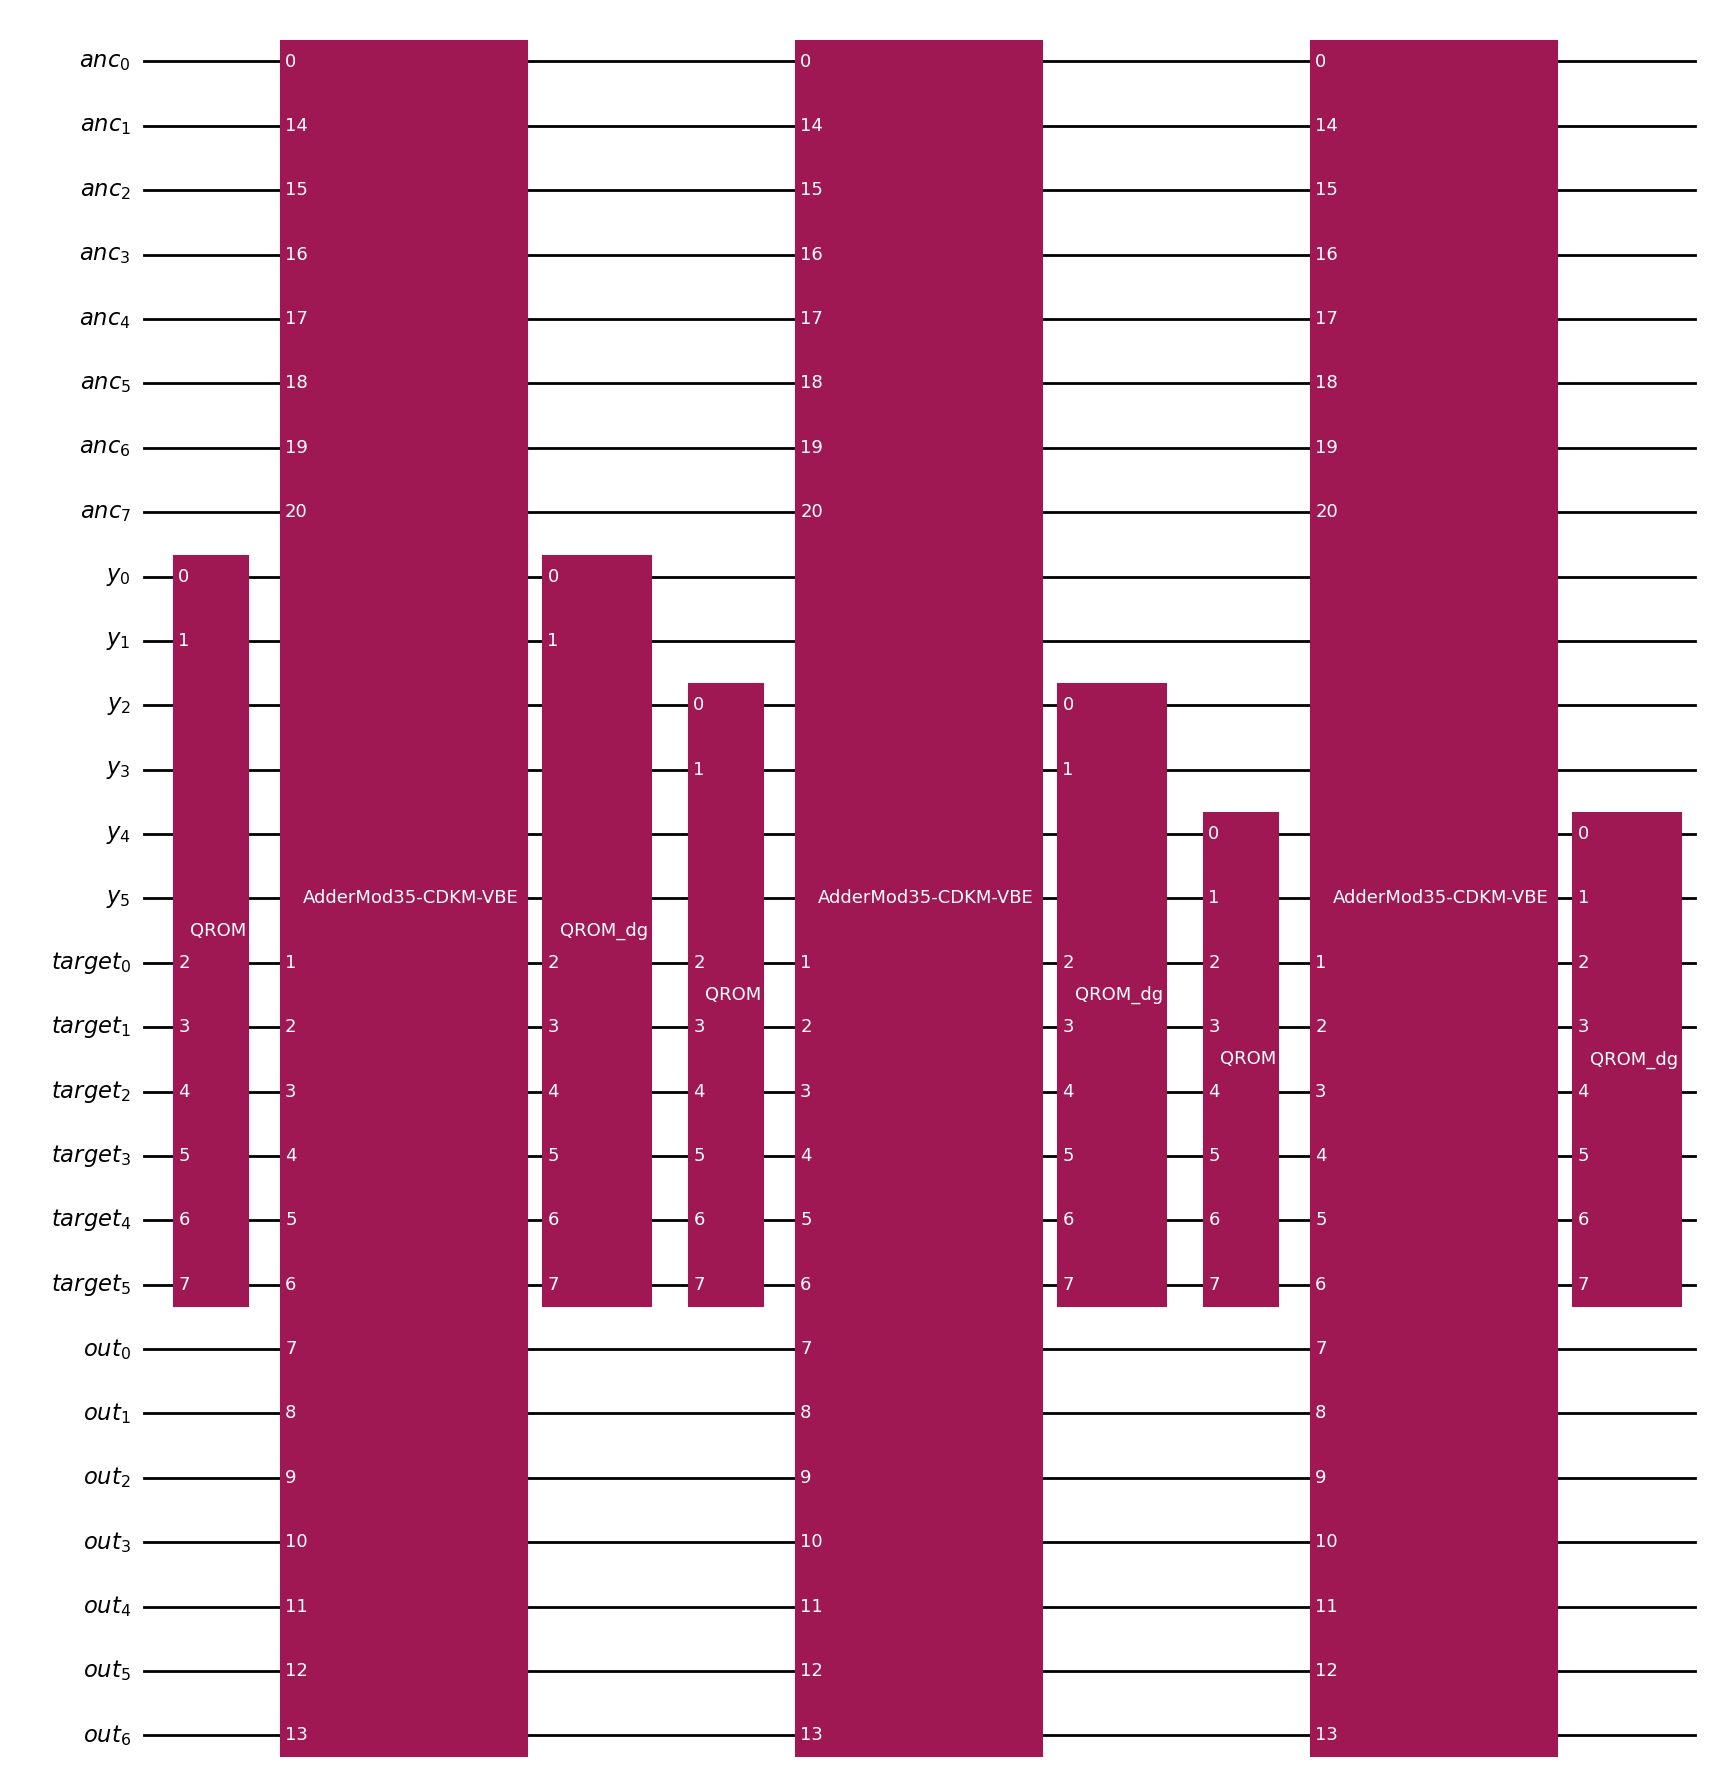

In [7]:
from qiskit import *
from math import log2

def win_add_mod(N: int, w: int, n: int, k: int) -> QuantumCircuit:
    """
    Args:
        N (int): the modulus.
        w (int): the addition window size.
        n (int): bit size of the operand.
        k (int): constant to multiply y.
        
    Returns:
        quantum_circuit (QuantumCircuit): the plus equal product mod `x += ky mod N` circuit.
    """
    #ideal w = lg n

    reg_y = QuantumRegister(n, 'y')
    reg_t = QuantumRegister(n, 'target')
    reg_o = QuantumRegister(n+1, 'out')
    reg_anc = QuantumRegister(n+2, 'anc')


    quantum_circuit = QuantumCircuit(reg_anc,reg_y, reg_t, reg_o, name="win_add_mod")


    #anc, a, b, cO, n, help

    #for each window i  "range(0, len(y), w)"
        #win = y[i:i + w]
        #compute the lookup table (j*k*2^i mod N for j in range(2^w))
        #target += table[win]
    for i in range(0, n, w):
        table = [j * k * 2**i % N for j in range(2**w)]
        qrom = compute_lookup_table(w, n, table, optimization=1)
        quantum_circuit.append(qrom, reg_y[i:i + w] + reg_t[:])
        quantum_circuit.append(mod_adder_CDKM_VBE(n, N), reg_anc[0:1] + reg_t[:] + reg_o[:] + reg_anc[1:])
        quantum_circuit.append(qrom.inverse(), reg_y[i:i + w] + reg_t[:])
        
        #xor qrom into targer
        #add target into out
        #undo qrom xor
        #repeat

    return quantum_circuit

win_add_mod(35,2,6, k=1).draw("mpl")


In [9]:
from qiskit.quantum_info import Statevector
#"00000|0000|0001|000000"

Statevector.from_label("0001100000011000000").evolve(win_add_mod(15,2,4,k=2)).draw("latex")

Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}


<IPython.core.display.Latex object>

Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outpu

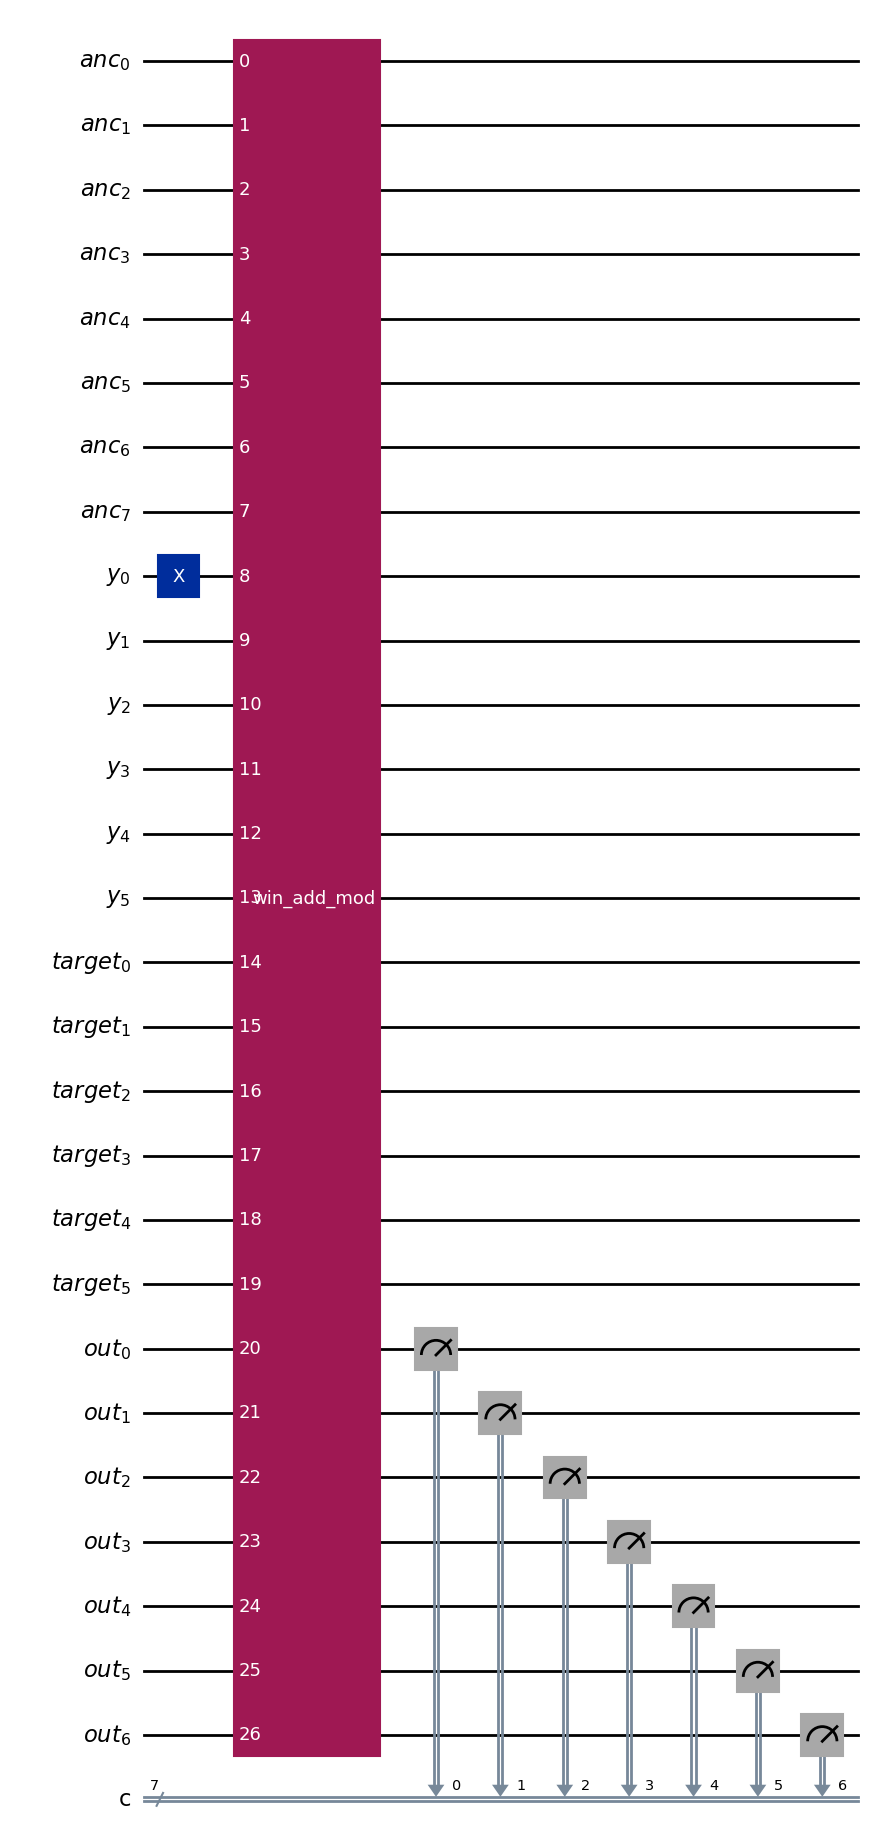

In [8]:
from qiskit.quantum_info import Statevector
#"00000|0000|0000|000000"
n = 6
reg_y = QuantumRegister(n, 'y')
reg_t = QuantumRegister(n, 'target')
reg_o = QuantumRegister(n+1, 'out')
reg_anc = QuantumRegister(n+2, 'anc')
reg_c = ClassicalRegister(n+1, 'c')
quantum_circuit = QuantumCircuit(reg_anc,reg_y, reg_t, reg_o, reg_c)

quantum_circuit.x(reg_y[0])
quantum_circuit.append(win_add_mod(35,2,n), reg_anc[:] + reg_y[:] + reg_t[:] + reg_o[:])
quantum_circuit.measure(reg_o, reg_c)
quantum_circuit.draw("mpl")

In [9]:
def modinv(a, n):
    t, new_t = 0, 1
    r, new_r = n, a
    while new_r != 0:
        quotient = r // new_r
        t, new_t = new_t, t - quotient * new_t
        r, new_r = new_r, r - quotient * new_r
    if r > 1:
        return None
    if t < 0:
        t = t + n
    return t

print(modinv(2, 15)) 


8


Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outpu

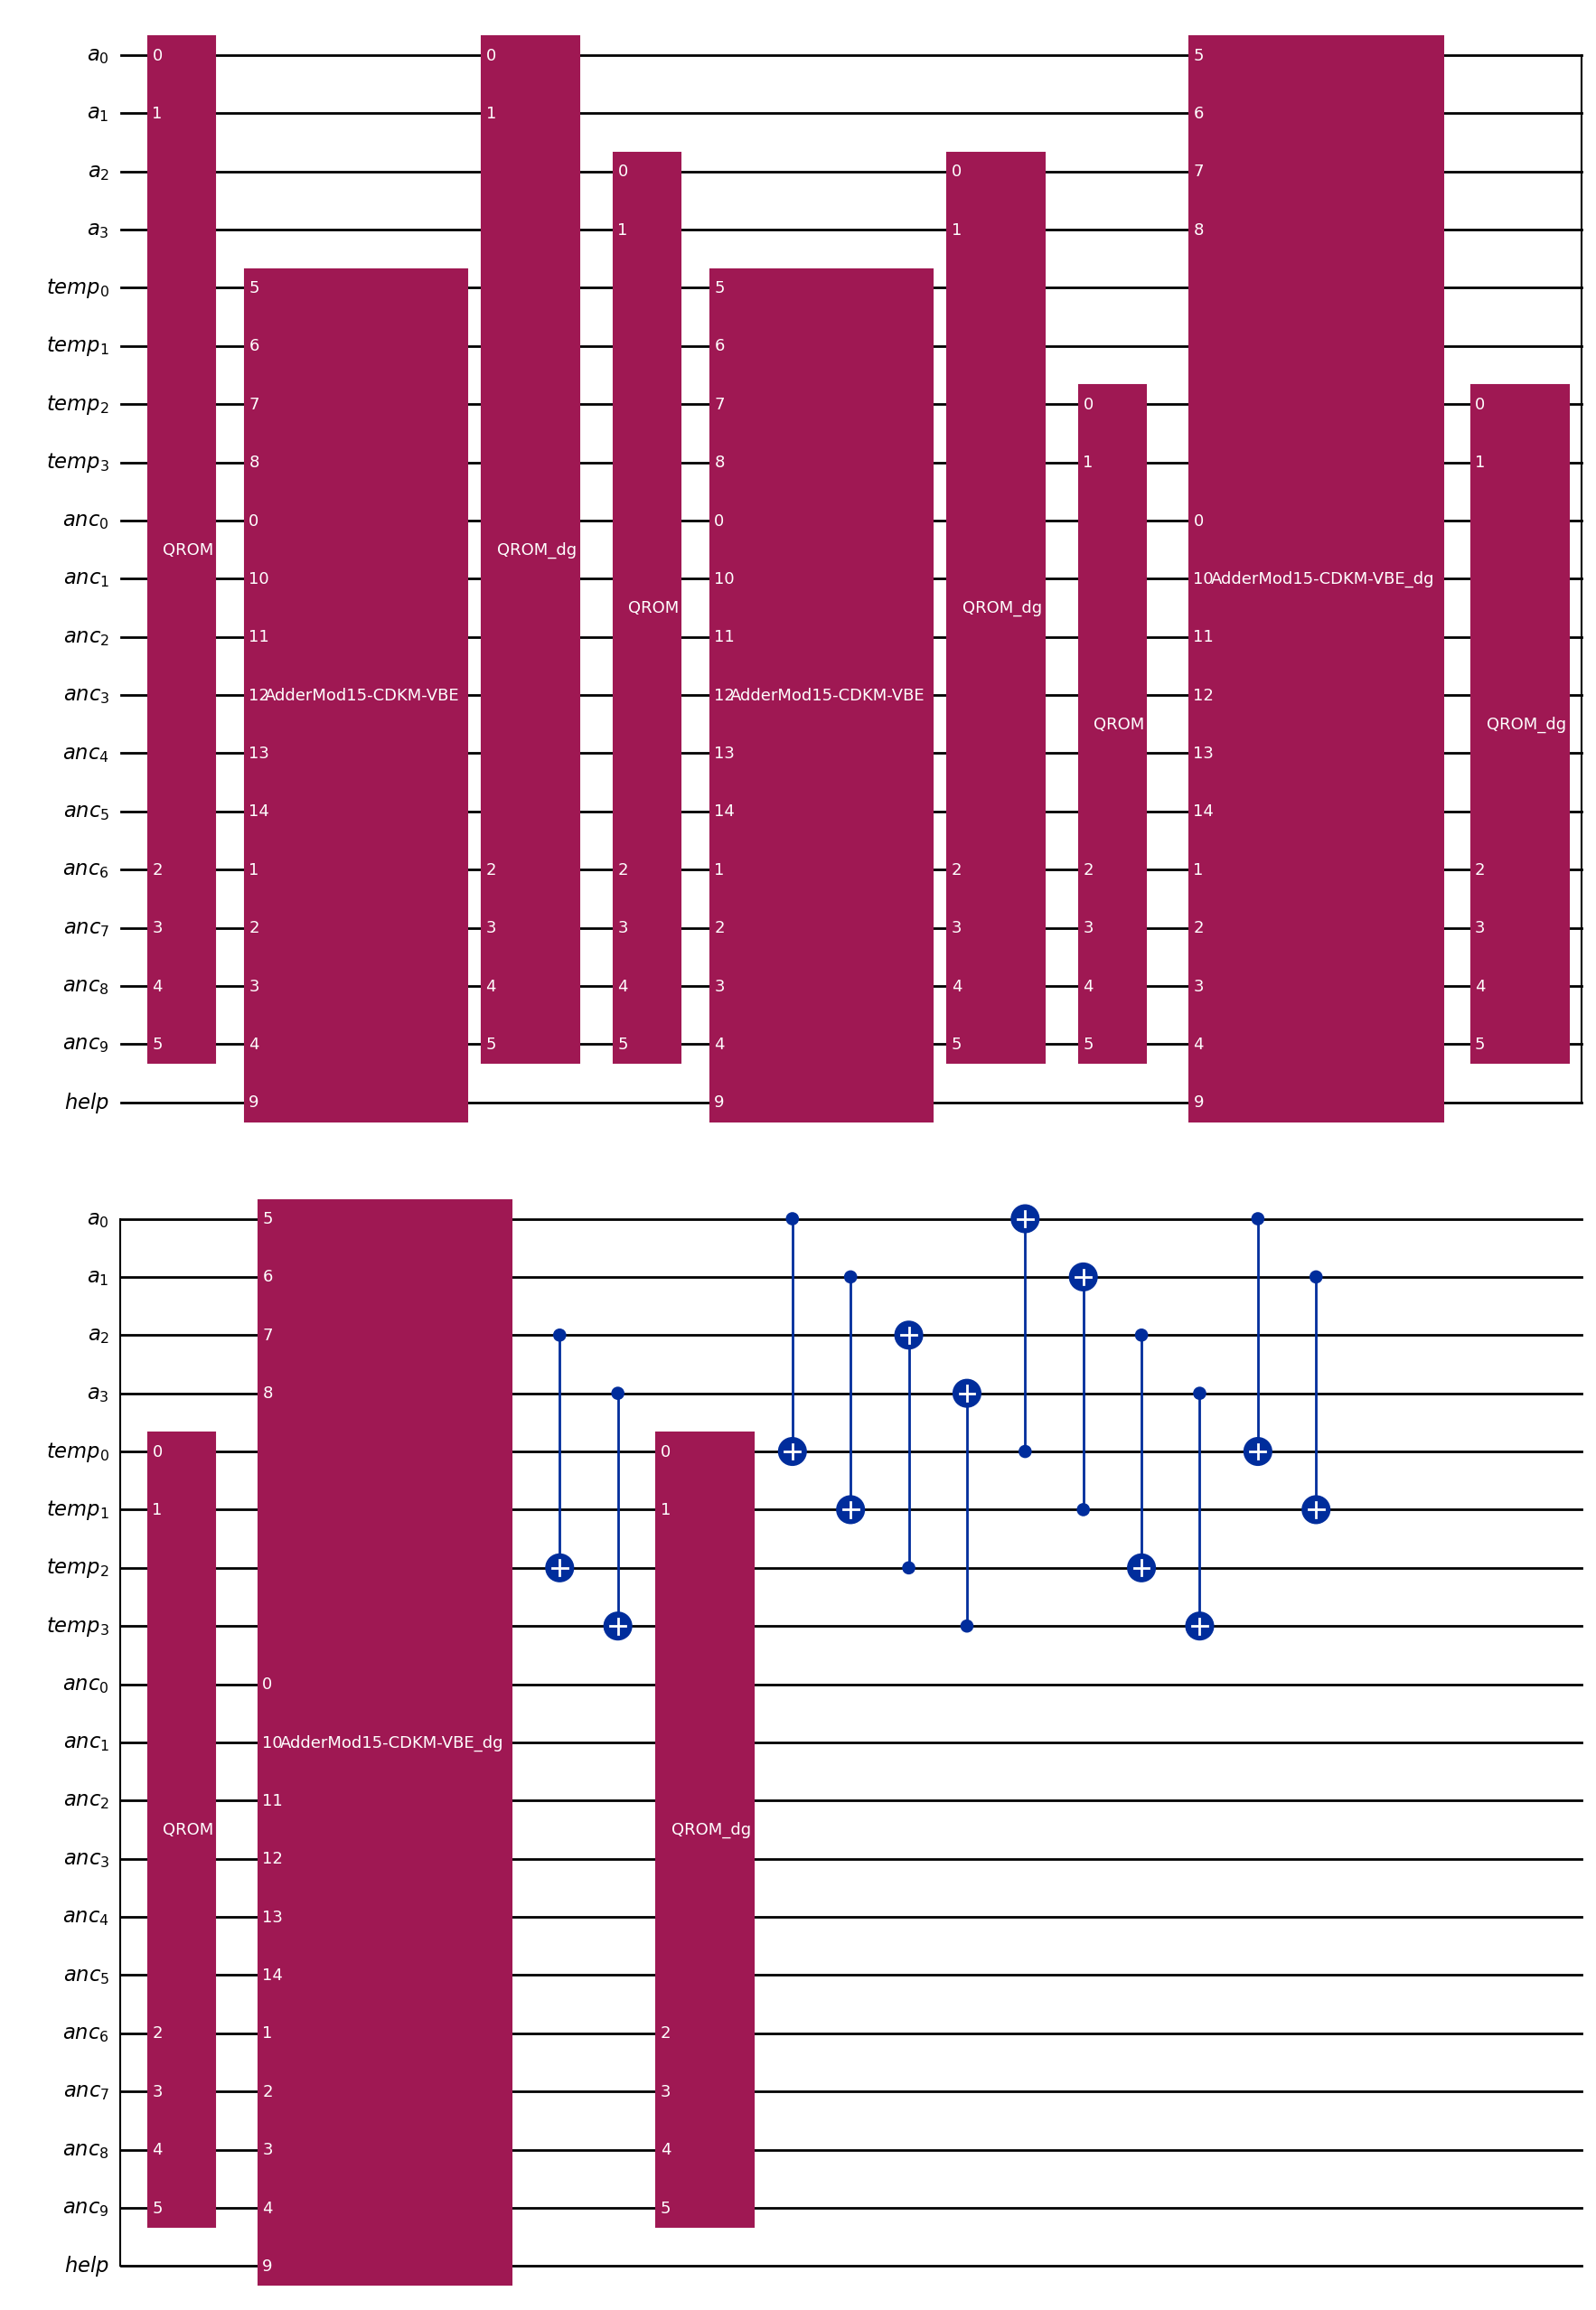

In [9]:
def win_mult_mod(N: int, w: int, n: int, k: int ):

    reg_a = QuantumRegister(n, 'a')
    reg_temp = QuantumRegister(n, 'temp')
    reg_help = QuantumRegister(1, 'help') # used as cOut for adder
    reg_anc = QuantumRegister(2*n+2, 'anc')

    quantum_circuit = QuantumCircuit(reg_a, reg_temp, reg_anc, reg_help, name="win_mult_mod")

    quantum_circuit.append(win_add_mod(N, w, n, k), reg_anc[0:n+2] + reg_a[:] + reg_anc[n+2:] + reg_temp[:] + reg_help[:])
    quantum_circuit.append(win_add_mod(N, w, n, modinv(k, N)).inverse(), reg_anc[0:n+2] + reg_temp[:] + reg_anc[n+2:] + reg_a[:] + reg_help[:])
    quantum_circuit.swap(reg_a, reg_temp)

    #win add where y = reg a, out = reg temp, k = k
    #win add where y = reg temp, out = reg a, k = (-k)^-1
    #swap reg a, reg temp
    return quantum_circuit

win_mult_mod(15,2,4,2).decompose().draw("mpl")

In [27]:
from qiskit.quantum_info import Statevector
#test win mult mod
# 0|0000000000|0000|0010
Statevector.from_label("0000000000000000010").evolve(win_mult_mod(15,2,4,2)).draw("latex")

Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outputs): 3
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2}
Total Quantum Qubits: 3
Total Classical Bits (for outpu

<IPython.core.display.Latex object>

In [222]:
def win_exp_mod(N: int, k: int, n: int, ne: int, we: int = 0, wm: int = 0) -> QuantumCircuit:
    """Algorithm works by iterating over the exponent window, every iteration multiplies the result register by k^(2^(i)*current_window).
    example: 3^11, 11 in bin = 1011, with we=2, 2 windows = [10,11], [2,3]
    1 * 3^(2^0 * 3) = 27
    27 * 3^(2^2 * 2) = 177147

    Args:
        N (int): the modulus.
        k (int): the base of the exponentiation.
        n (int): register bit size.
        ne (int): exponent bit size.
        we (int): exponentiation window size.
        wm (int): multiplication window size.

    Returns:
        quantum_circuit (QuantumCircuit): the times equal exp mod `x *= k^e mod N` circuit.
    """

    assert modinv(k, N) is not None, "k must be coprime to N for the algorithm to work."

    reg_e = QuantumRegister(ne, name="input e")
    reg_a = QuantumRegister(n, name="input a")
    reg_t = QuantumRegister(n, name="target")
    reg_o = QuantumRegister(n, name="output")
    reg_temp = QuantumRegister(n, name="temp")
    reg_help = QuantumRegister(1, name="help")  # used as cOut for adder
    reg_anc = QuantumRegister(n+2, name="anc")

    quantum_circuit = QuantumCircuit(reg_e, reg_a, reg_t, reg_o, reg_temp, reg_help, reg_anc, name="win_add_mod_expVer")


    for i in range(ne-we, -1, -we):
        # Exponent - indexed factors and inverse factors .
        kes = [pow(k, 2**i * x, N) for x in range(2**we)]
        kes_inv = [modinv(x, N) for x in kes]

        for j in range(0, n, wm):
            table = [(ke * f * 2**j) % N for f in range(2**wm) for ke in kes]
            qrom = compute_lookup_table(we+wm, n, table, optimization=1)
            quantum_circuit.append(qrom, reg_e[i:i + we] + reg_a[j:j + wm] + reg_t[:])
            quantum_circuit.append(mod_adder_CDKM_VBE(n, N), reg_anc[0:1] + reg_t[:] + reg_o[:] + reg_help[:] + reg_anc[1:])
            quantum_circuit.append(qrom.inverse(), reg_e[i:i + we] + reg_a[j:j + wm] + reg_t[:])

        for j in range(0, n, wm):
            table = [(ke_inv * f * 2**j) % N for f in  range(2**wm) for ke_inv in kes_inv]
            qrom = compute_lookup_table(we+wm, n, table, optimization=1)
            quantum_circuit.append(qrom, reg_e[i:i + we] + reg_o[j:j+wm] + reg_t[:])
            quantum_circuit.append(mod_adder_CDKM_VBE(n, N).inverse(), reg_anc[0:1] + reg_t[:] + reg_a[:] + reg_help[:] + reg_anc[1:])
            quantum_circuit.append(qrom.inverse(), reg_e[i:i + we] + reg_o[j:j+wm] + reg_t[:])

        quantum_circuit.swap(reg_a, reg_o)

    return quantum_circuit

Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qu

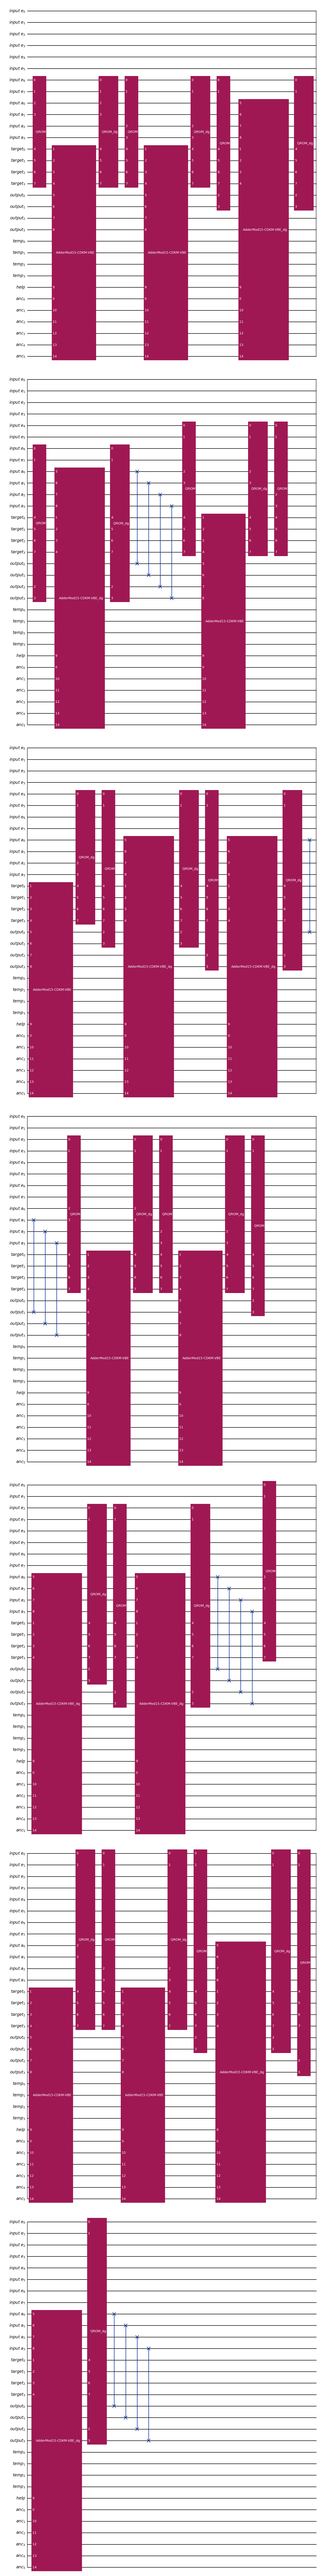

In [223]:
win_exp_mod(15, 11, 4, 8, 2, 2).draw("mpl")

Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qu

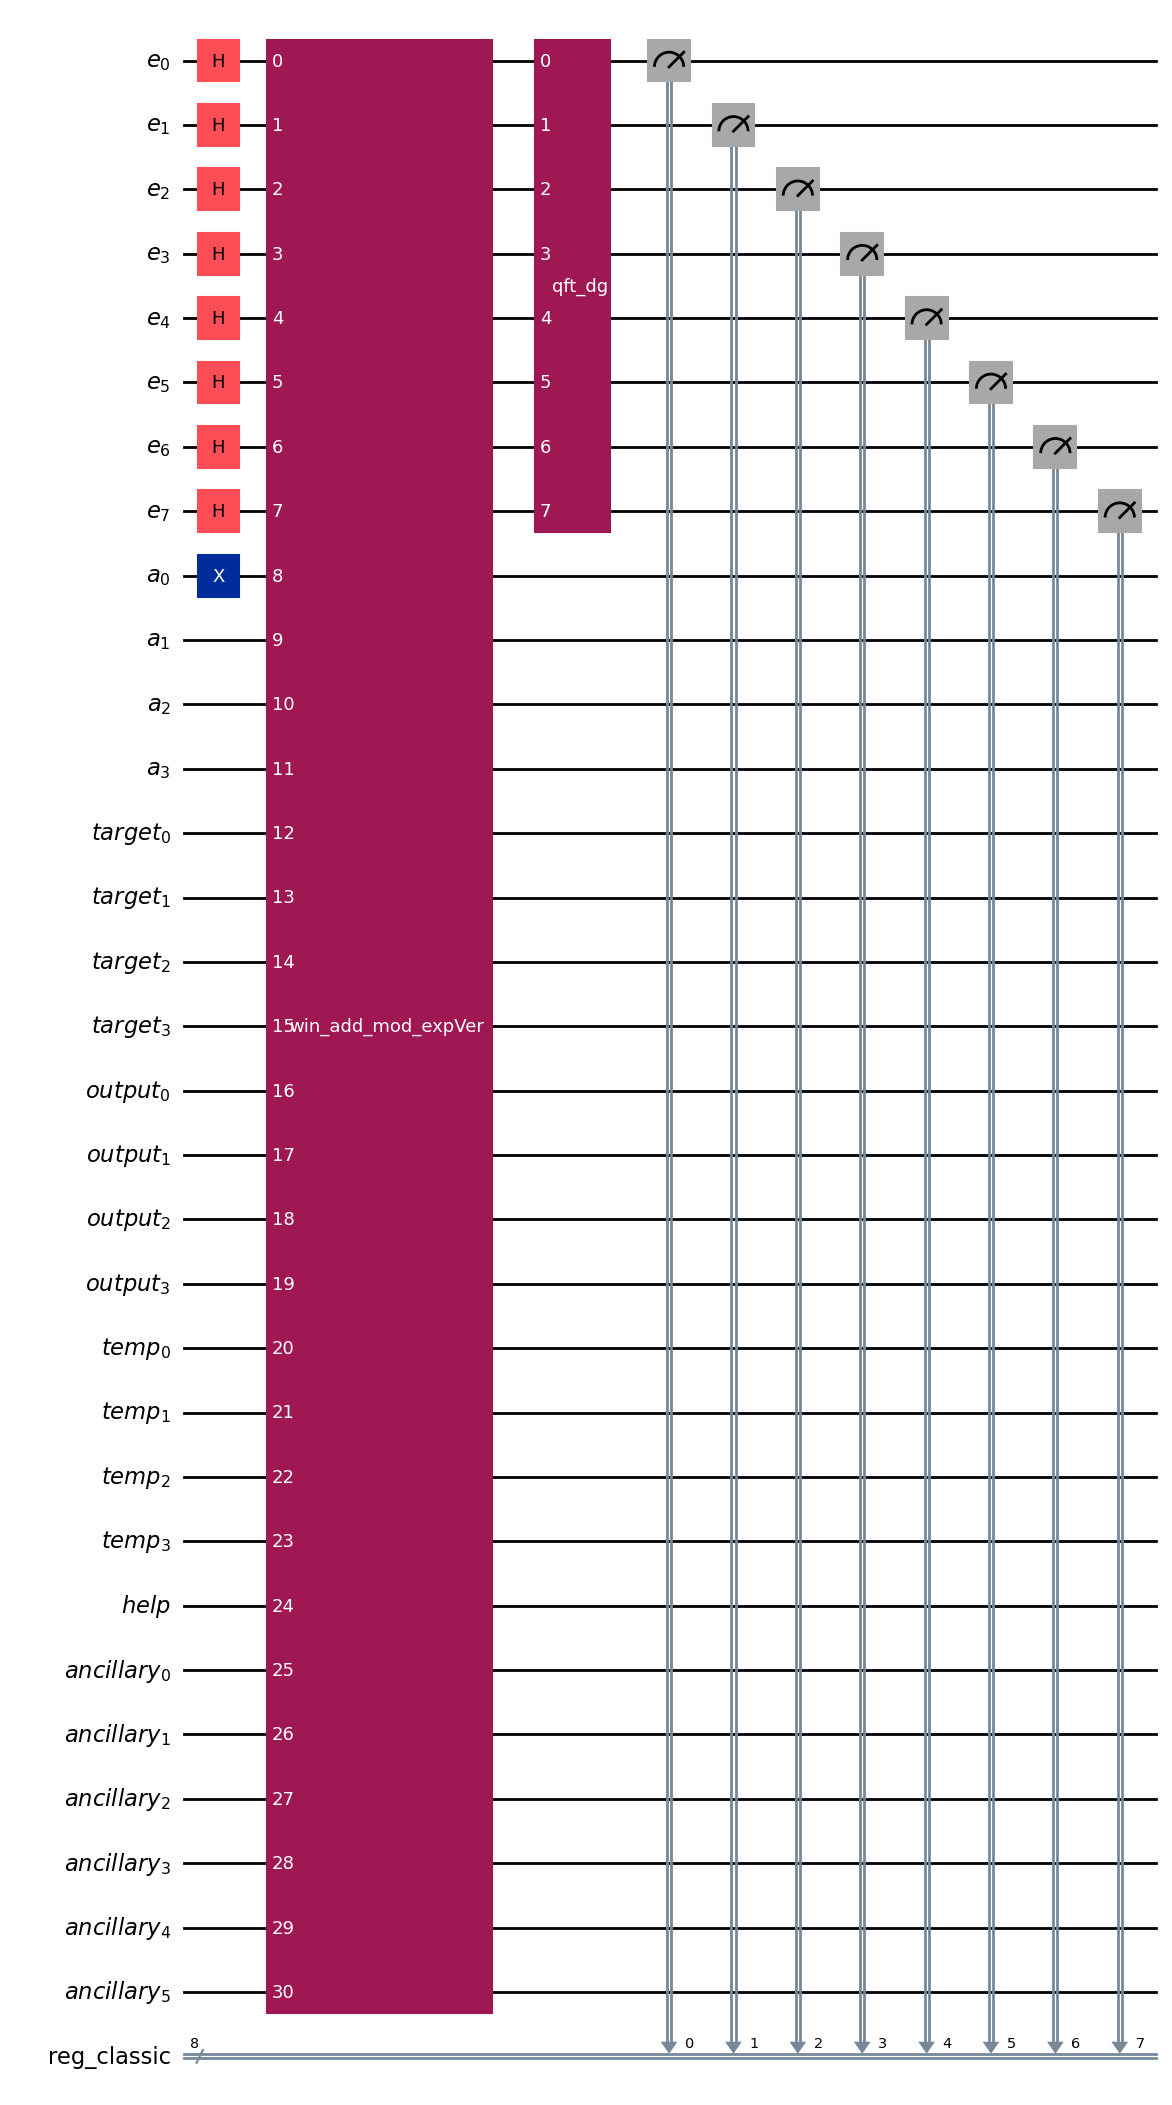

In [224]:
from qiskit.circuit.library import QFTGate
reg_e = QuantumRegister(8, name="e")
reg_a = QuantumRegister(4, name="a")
reg_t = QuantumRegister(4, name="target")
reg_o = QuantumRegister(4, name="output")
reg_temp = QuantumRegister(4, name="temp")
reg_help = QuantumRegister(1, name="help")
reg_anc = QuantumRegister(6, name="ancillary")
reg_classic = ClassicalRegister(8, name="reg_classic")
qc = QuantumCircuit(reg_e, reg_a, reg_t, reg_o, reg_temp, reg_help, reg_anc, reg_classic)
qc.h(reg_e)
qc.x(reg_a[0])
qc.append(win_exp_mod(15, 2, 4, 8, 2, 2), reg_e[:] + reg_a[:] + reg_t[:] + reg_o[:] + reg_temp[:] + reg_help[:] + reg_anc[:])
qc.append(QFTGate(8).inverse(), reg_e[:])
qc.measure(reg_e, reg_classic)
qc.draw("mpl")

In [225]:
from qiskit_aer import QasmSimulator


backend1 = QasmSimulator()
backend1.set_max_qubits(31)
qc1 = transpile(qc, backend=backend1)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1024)

counts = job.result()[0].data.reg_classic.get_int_counts()

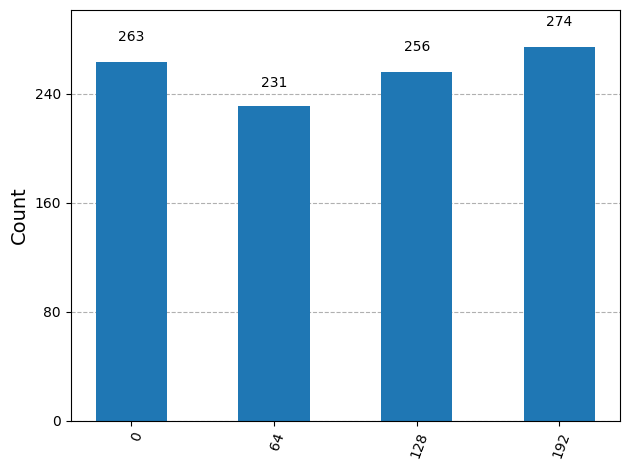

In [226]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

In [50]:
from qiskit import *
from math import log2, ceil


def modinv(a: int, n: int) -> int:
    t, new_t = 0, 1
    r, new_r = n, a
    while new_r != 0:
        quotient = r // new_r
        t, new_t = new_t, t - quotient * new_t
        r, new_r = new_r, r - quotient * new_r
    if r > 1:
        return None
    if t < 0:
        t = t + n
    return t


def win_exp_mod(N: int, k: int, n: int, ne: int, we: int = 0, wm: int = 0) -> QuantumCircuit:
    """Algorithm works by iterating over the exponent window, every iteration multiplies the result register by k^(2^(i)*current_window).
    example: 3^11, 11 in bin = 1011, with we=2, 2 windows = [10,11], [2,3]
    1 * 3^(2^0 * 3) = 27
    27 * 3^(2^2 * 2) = 177147

    Args:
        N (int): the modulus.
        k (int): the base of the exponentiation.
        n (int): register bit size.
        ne (int): exponent bit size.
        we (int): exponentiation window size.
        wm (int): multiplication window size.

    Returns:
        quantum_circuit (QuantumCircuit): the times equal exp mod `x *= k^e mod N` circuit.
    """

    assert modinv(k, N) is not None, "k must be coprime to N for the algorithm to work."

    reg_e = QuantumRegister(we, name="input e")
    reg_a = QuantumRegister(n, name="input a")
    reg_t = QuantumRegister(n, name="target")
    reg_o = QuantumRegister(n, name="output")
    reg_temp = QuantumRegister(n, name="temp")
    reg_help = QuantumRegister(1, name="help")  # used as cOut for adder
    reg_anc = QuantumRegister(n+2, name="anc")
    reg_c = ClassicalRegister(4, name="auxE")

    quantum_circuit = QuantumCircuit(reg_e, reg_a, reg_t, reg_o, reg_temp, reg_help, reg_anc, reg_c, name="win_add_mod_expVer")

    quantum_circuit.x(reg_a[0])

    for i in range(0, ne, we):
        # Exponent - indexed factors and inverse factors .
        kes = [pow(k, 2**i * x, N) for x in range(2**we)]
        kes_inv = [modinv(x, N) for x in kes]
        
        quantum_circuit.h(reg_e)

        for j in range(0, n, wm):
            table = [(ke * f * 2**j) % N for f in range(2**wm) for ke in kes]
            qrom = compute_lookup_table(we+wm, n, table, optimization=1)
            quantum_circuit.append(qrom, reg_e[:] + reg_a[j:j + wm] + reg_t[:])
            quantum_circuit.append(mod_adder_CDKM_VBE(n, N), reg_anc[0:1] + reg_t[:] + reg_o[:] + reg_help[:] + reg_anc[1:])
            quantum_circuit.append(qrom.inverse(), reg_e[:] + reg_a[j:j + wm] + reg_t[:])

        for j in range(0, n, wm):
            table = [(ke_inv * f * 2**j) % N for f in  range(2**wm) for ke_inv in kes_inv]
            qrom = compute_lookup_table(we+wm, n, table, optimization=1)
            quantum_circuit.append(qrom, reg_e[:] + reg_o[j:j+wm] + reg_t[:])
            quantum_circuit.append(mod_adder_CDKM_VBE(n, N).inverse(), reg_anc[0:1] + reg_t[:] + reg_a[:] + reg_help[:] + reg_anc[1:])
            quantum_circuit.append(qrom.inverse(), reg_e[:] + reg_o[j:j+wm] + reg_t[:])

        quantum_circuit.swap(reg_a, reg_o)

        quantum_circuit.measure(reg_e, reg_c[0:we])
        quantum_circuit.reset(reg_e)

    quantum_circuit.measure(reg_a, reg_c)

    return quantum_circuit

Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qu

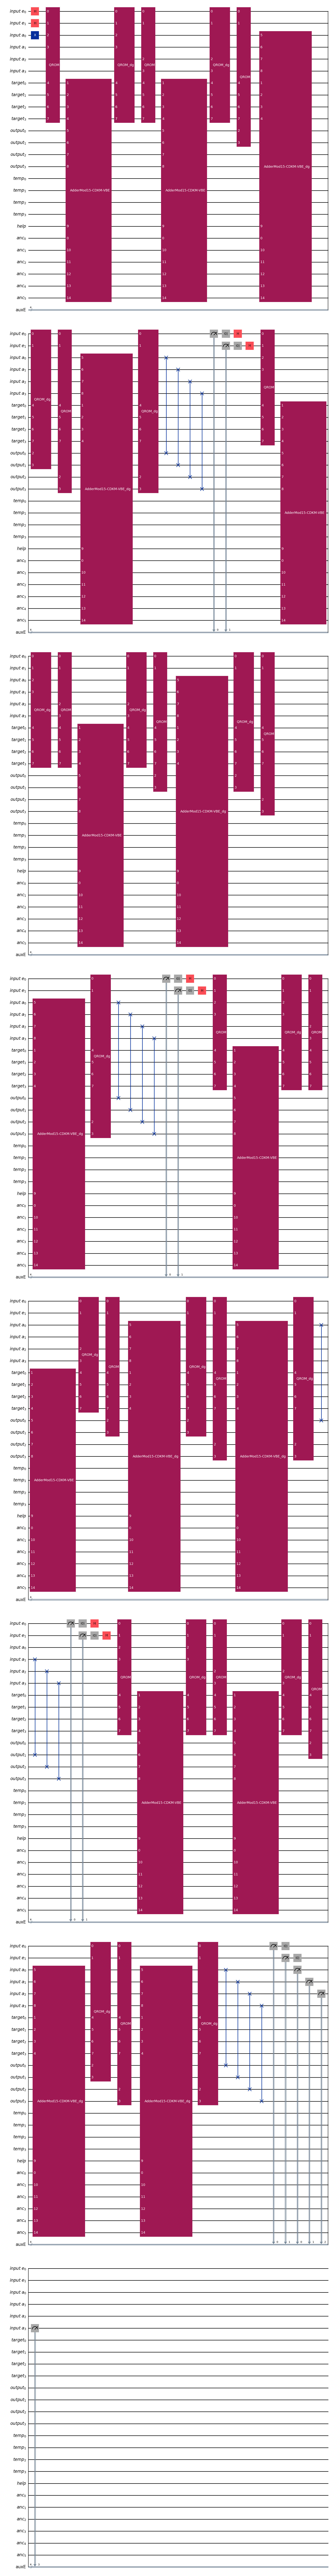

In [51]:
win_exp_mod(15, 2, 4, 8, 2, 2).draw("mpl")

In [52]:
qc = win_exp_mod(15, 2, 4, 8, 2, 2)

from qiskit_aer import AerSimulator


backend1 = AerSimulator()
backend1.set_max_qubits(31)
qc1 = transpile(qc, backend=backend1)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=100)

counts = job.result()[0].data.auxE.get_int_counts()

Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qu

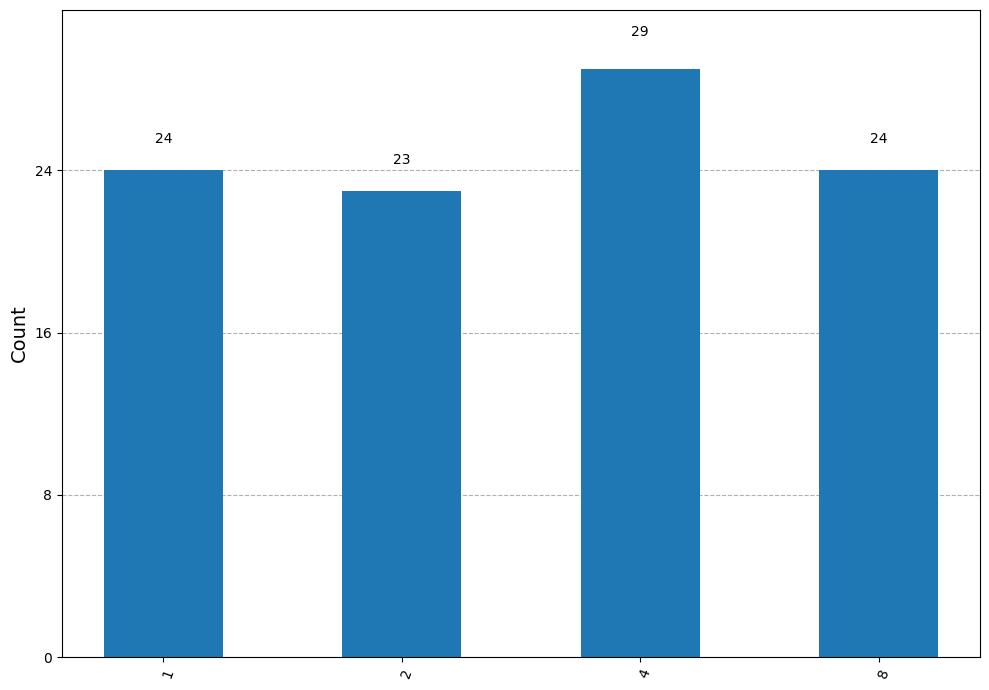

In [53]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, figsize=(10,7))

In [269]:
from qiskit import *
from math import log2, ceil, pi
from qiskit.circuit.library import QFTGate


def modinv(a: int, n: int) -> int:
    t, new_t = 0, 1
    r, new_r = n, a
    while new_r != 0:
        quotient = r // new_r
        t, new_t = new_t, t - quotient * new_t
        r, new_r = new_r, r - quotient * new_r
    if r > 1:
        return None
    if t < 0:
        t = t + n
    return t


def win_exp_mod_semi_class(N: int, k: int, n: int, ne: int, we: int = 0, wm: int = 0) -> QuantumCircuit:
    """Algorithm works by iterating over the exponent window, every iteration multiplies the result register by k^(2^(i)*current_window).
    example: 3^11, 11 in bin = 1011, with we=2, 2 windows = [10,11], [2,3]
    1 * 3^(2^0 * 3) = 27
    27 * 3^(2^2 * 2) = 177147

    Args:
        N (int): the modulus.
        k (int): the base of the exponentiation.
        n (int): register bit size.
        ne (int): exponent bit size.
        we (int): exponentiation window size.
        wm (int): multiplication window size.

    Returns:
        quantum_circuit (QuantumCircuit): the times equal exp mod `x *= k^e mod N` circuit.
    """

    assert modinv(k, N) is not None, "k must be coprime to N for the algorithm to work."

    reg_e = QuantumRegister(we, name="input e")
    reg_a = QuantumRegister(n, name="input a")
    reg_t = QuantumRegister(n, name="target")
    reg_o = QuantumRegister(n, name="output")
    reg_temp = QuantumRegister(n, name="temp")
    reg_help = QuantumRegister(1, name="help")  # used as cOut for adder
    reg_anc = QuantumRegister(n+2, name="anc")
    reg_c = ClassicalRegister(2*n, name="auxE")

    quantum_circuit = QuantumCircuit(reg_e, reg_a, reg_t, reg_o, reg_temp, reg_help, reg_anc, reg_c, name="win_add_mod_expVer")

    quantum_circuit.x(reg_a[0])

    for i in range(ne-we, -1, -we):
        # Exponent - indexed factors and inverse factors .
        kes = [pow(k, 2**i * x, N) for x in range(2**we)]
        print(i)
        print(kes)
        kes_inv = [modinv(x, N) for x in kes]
        
        quantum_circuit.h(reg_e)

        for j in range(0, n, wm):
            table = [(ke * f * 2**j) % N for f in range(2**wm) for ke in kes]
            qrom = compute_lookup_table(we+wm, n, table, optimization=1)
            quantum_circuit.append(qrom, reg_e[:] + reg_a[j:j + wm] + reg_t[:])
            quantum_circuit.append(mod_adder_CDKM_VBE(n, N), reg_anc[0:1] + reg_t[:] + reg_o[:] + reg_help[:] + reg_anc[1:])
            quantum_circuit.append(qrom.inverse(), reg_e[:] + reg_a[j:j + wm] + reg_t[:])

        for j in range(0, n, wm):
            table = [(ke_inv * f * 2**j) % N for f in range(2**wm) for ke_inv in kes_inv]
            qrom = compute_lookup_table(we+wm, n, table, optimization=1)
            quantum_circuit.append(qrom, reg_e[:] + reg_o[j:j+wm] + reg_t[:])
            quantum_circuit.append(mod_adder_CDKM_VBE(n, N).inverse(), reg_anc[0:1] + reg_t[:] + reg_a[:] + reg_help[:] + reg_anc[1:])
            quantum_circuit.append(qrom.inverse(), reg_e[:] + reg_o[j:j+wm] + reg_t[:])

        quantum_circuit.swap(reg_a, reg_o)


        for j in range(we, ne-i):
            with quantum_circuit.if_test((reg_c[j-we], 1)):
                for s in range(0, we):
                    quantum_circuit.p((-pi/(2**(ne-i-j+s))), reg_e[s])

        #for s in range(0, we):
        #    for d in range(0, s):
        #        quantum_circuit.cp((-pi/(2**(s-d))), reg_e[d:d+1], reg_e[s:s+1])
        #    quantum_circuit.h(reg_e[s:s+1])
        for s in range(0, we):
            for d in range(0, s):
                quantum_circuit.rz((pi/(2**s-d)), reg_e[s:s+1])
                quantum_circuit.cx(reg_e[d:d+1], reg_e[s:s+1])
                quantum_circuit.rz((-pi/(2**s-d)), reg_e[s:s+1])
                quantum_circuit.cx(reg_e[d:d+1], reg_e[s:s+1])
                quantum_circuit.rz((pi/(2**s-d)), reg_e[d:d+1])
            quantum_circuit.h(reg_e[s:s+1])

        quantum_circuit.measure(reg_e[:], reg_c[ne-i-we:ne-i])
        quantum_circuit.reset(reg_e)

    return quantum_circuit

6
[1, 1, 1, 1]
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
T

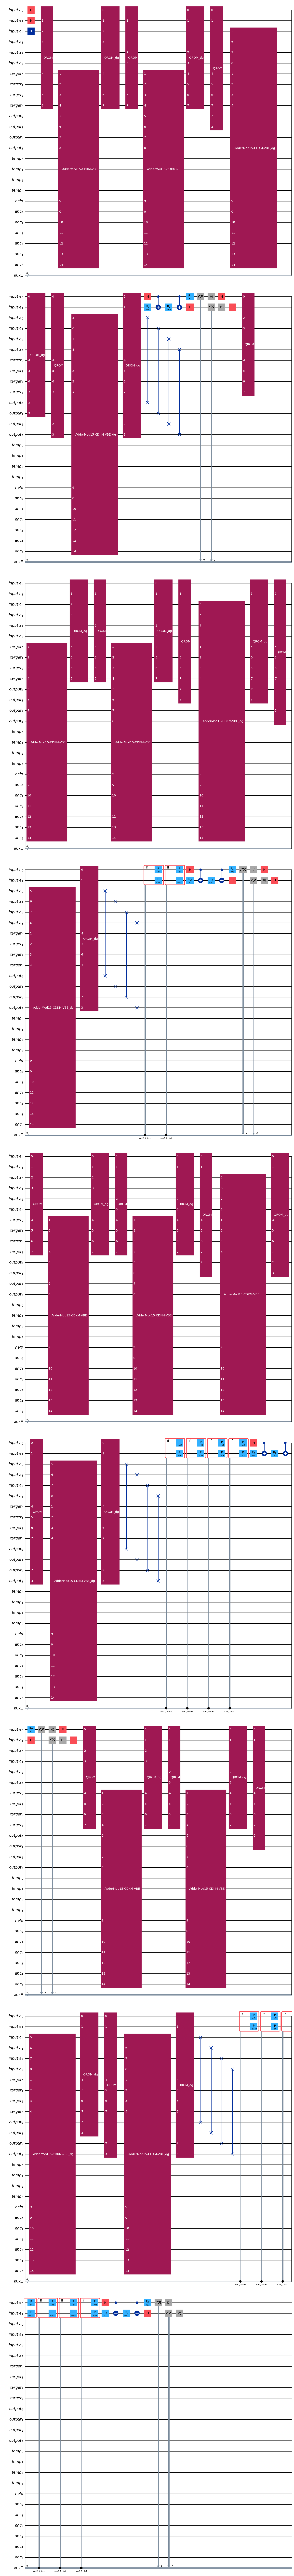

In [270]:
win_exp_mod_semi_class(15, 2, 4, 8, 2, 2).draw("mpl")

In [271]:
qc = win_exp_mod_semi_class(15, 2, 4, 8, 2, 2)

6
[1, 1, 1, 1]
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
Total Quantum Qubits: 5
Total Classical Bits (for outputs): 5
Qubit Mapping: {'b0': 0, 'b1': 1, 'b2': 2, 'b3': 3, 'b4': 4}
T

In [272]:
from qiskit_aer import AerSimulator


backend1 = AerSimulator()
backend1.set_max_qubits(31)
qc1 = transpile(qc, backend=backend1)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=200)

counts = job.result()[0].data.auxE.get_int_counts()

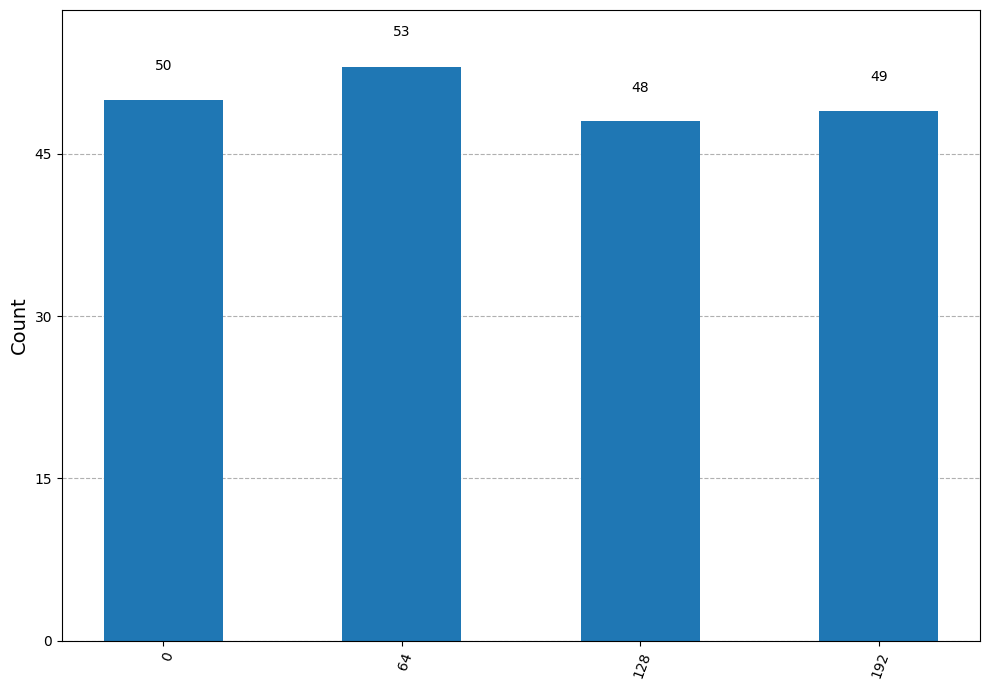

In [273]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, figsize=(10,7))

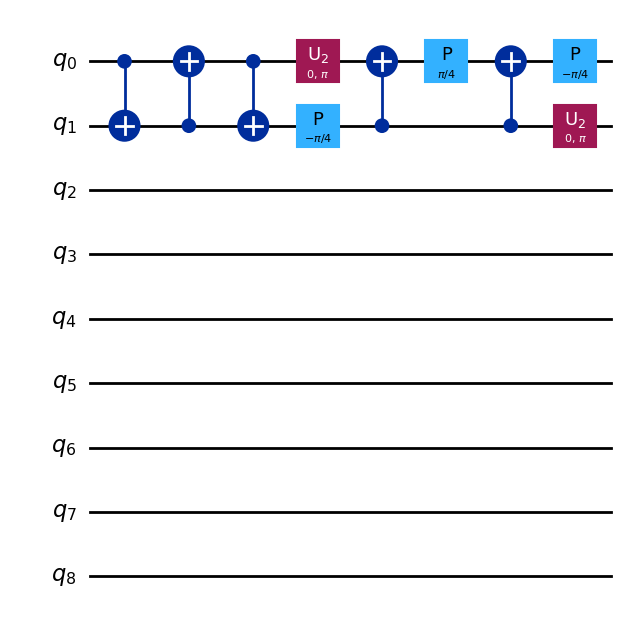

In [161]:
qc = QuantumCircuit(9)
n = 2
qc.append(QFTGate(n).inverse(), [i for i in range(n)])
#for s in range(0, 5):
#    for d in range(0, s):
#        qc.cp((-pi/(2**(s-d))), d, s)
#    qc.h(s)
qc.decompose().decompose().draw("mpl")